# Battle of the Bands<a name="top"></a>

This is the slightly generic version of [Battle of the Bands: Data gathering](beatles-vs-stones-gather-data.ipynb). Look there for a description of the contents of this notebook.

## Contents: Data gathering

* [Getting data from Spotify](#getspotify)
* [Tag album with artist](#tagalbumwithartist)
* [Tag track with artist](#tagtrackwithartist)
* [Get full track data](#fulltrackdata)
* [Lyrics search](#lyricssearch)
* [Matching datasets](#matchingdatasets)
* [Copy the lyrics over](#copylyrics)
* [Sentiment analysis](#sentimentanalysis)


In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import urllib.request
import urllib.parse
import urllib.error
import json
import base64
import configparser
from bs4 import BeautifulSoup
import re
import pymongo
from datetime import datetime
import time
import collections

We'll use MongoDB to store the data, to save keeping it all in memory, and mean we don't have to recapture all the data to to a different analysis.

In [2]:
# Open a connection to the Mongo server
client = pymongo.MongoClient('mongodb://localhost:27017/')

In [3]:
# try:
#     client.drop_database(songs_db)
# except NameError:
#     print("DB doesn't exist yet.")

In [4]:
# Create a database and a collections within it.
songs_db = client.songs
albums = songs_db.albums
tracks = songs_db.tracks
genius_tracks = songs_db.gtracks

API keys and the like are kept in a configuration file, which is read here.

You'll need to create a web API key for Spotify and Genius. 

In [5]:
config = configparser.ConfigParser()
config.read('secrets.ini')
[k for k in config['genius']]

['app_name', 'client_id', 'client_secret', 'redirect_uri', 'token']

In [6]:
## How to write the config file. Fill in the details, and create a different config section for Spotify.
# config['genius'] = {}
# config['genius']['app_name'] = 'xxx'
# config['genius']['client_id'] = 'xxx'
# config['genius']['client_secret'] = 'xxx'
# config['genius']['token'] = 'xxx'
# with open('secrets.ini', 'w') as configfile:
#     config.write(configfile)

In [37]:
stones_id = '22bE4uQ6baNwSHPVcDxLCe'
beatles_id = '3WrFJ7ztbogyGnTHbHJFl2'
radiohead_id = '4Z8W4fKeB5YxbusRsdQVPb'

# Get album and track data from Spotify<a name='getspotify'></a>
We'll download the data on artists, albums, and tracks from Spotify.

* [Top](#top)

In [8]:
def get_spotify_auth_token():
    auth_url = 'https://accounts.spotify.com/api/token'
    auth_data = urllib.parse.urlencode({'grant_type': 'client_credentials'}).encode('utf-8')
    auth_id = base64.standard_b64encode((config['spotify']['client_id'] + \
        ':' + config['spotify']['client_secret']).encode('utf-8')).decode('utf-8)')
    auth_headers = {'Authorization': 'Basic ' + auth_id}
    auth_request = urllib.request.Request(auth_url, data=auth_data, headers=auth_headers)
    with urllib.request.urlopen(auth_request) as f:
        response = json.loads(f.read().decode('utf-8'))
        return response['token_type'], response['access_token']

In [10]:
def get_artists(artist_name, auth_type, auth_token):
    headers = {'Authorization': auth_type + ' ' + auth_token}
    query = urllib.parse.urlencode({'q': artist_name, 'type': 'artist'})
    url = 'https://api.spotify.com/v1/search?{}'.format(query)
    request = urllib.request.Request(url, headers=headers, method='GET')

    with urllib.request.urlopen(request) as f:
        response = json.loads(f.read().decode('utf-8'))
        artists = []
        for artist in response['artists']['items']:
            if artist['name'].lower() == artist_name.lower():
                this_artist = {'name': artist['name'], 'id': artist['id']}
                if artist['images']:
                    this_artist['image'] = artist['images'][0]['url']
                artists += [this_artist]
    return artists

In [385]:
a_type, a_token = get_spotify_auth_token()

In [386]:
artists = get_artists('Queen', a_type, a_token)
this_artist_id = artists[0]['id']
this_artist_id, artists

('1dfeR4HaWDbWqFHLkxsg1d',
 [{'id': '1dfeR4HaWDbWqFHLkxsg1d',
   'image': 'https://i.scdn.co/image/b040846ceba13c3e9c125d68389491094e7f2982',
   'name': 'Queen'},
  {'id': '6QWuYtzBkQ2Re44gRxaB2e',
   'image': 'https://i.scdn.co/image/8d95cd1630b207d11749082f1e7e4c5b698865a1',
   'name': 'Queen'}])

Find all the albums for an artist.

In [295]:
def get_albums(artist_id, auth_type, auth_token):
    headers = {'Authorization': auth_type + ' ' + auth_token}
    url = 'https://api.spotify.com/v1/artists/{a_id}/albums?market=GB&album_type=album'.format(a_id=artist_id)
    while url:
        request = urllib.request.Request(url, headers=headers, method='GET')
                
        for _ in range(10):
            try:
                f = urllib.request.urlopen(request)
                break
            except urllib.error.HTTPError as e:
                print("Rate limited. Pausing for", e.info()['Retry-After'])
                time.sleep(int(e.info()['Retry-After']) + 0.5)
                continue
        
        response = json.loads(f.read().decode('utf-8'))
        if 'next' in response:
            url = response['next']
        else:
            url = None
        for a in response['items']:
            album_url = a['href']
            album_request = urllib.request.Request(album_url, headers=headers, method='GET')
            with urllib.request.urlopen(album_request) as af:
                album = json.loads(af.read().decode('utf-8'))
                album['_id'] = album['id']
                albums.replace_one({'_id': album['_id']}, album, upsert=True)  

In [286]:
def get_albums_debug(artist_id, auth_type, auth_token):
    headers = {'Authorization': auth_type + ' ' + auth_token}
    url = 'https://api.spotify.com/v1/artists/{a_id}/albums?market=GB&album_type=album'.format(a_id=artist_id)
    request = urllib.request.Request(url, headers=headers, method='GET')
    with urllib.request.urlopen(request) as f:
        response = json.loads(f.read().decode('utf-8'))
        return response              

In [293]:
# resp = get_albums(this_artist_id, a_type, a_token)
# resp['next']

Rate limited. Pausing for 1
Rate limited. Pausing for 1
Rate limited. Pausing for 1
Rate limited. Pausing for 1
Rate limited. Pausing for 1
Rate limited. Pausing for 1
Rate limited. Pausing for 1
Rate limited. Pausing for 1
Rate limited. Pausing for 1
Rate limited. Pausing for 1
Rate limited. Pausing for 1
Rate limited. Pausing for 1
Rate limited. Pausing for 1
Rate limited. Pausing for 1
Rate limited. Pausing for 1
Rate limited. Pausing for 1
Rate limited. Pausing for 1
Rate limited. Pausing for 1
Rate limited. Pausing for 1
Rate limited. Pausing for 1
Rate limited. Pausing for 1


KeyboardInterrupt: 

In [13]:
def genius_song_search(artist_id):
    songs = pd.DataFrame()
    page = 1
    while page:
        query = urllib.parse.urlencode({'page': page, 'per_page': 20})
        headers = {'Accept': 'application/json',
               'Authorization': 'Bearer ' + config['genius']['token'],
               'User-Agent': 'curl/7.9.8 (i686-pc-linux-gnu) libcurl 7.9.8 (OpenSSL 0.9.6b) (ipv6 enabled)'}
        request = urllib.request.Request('https://api.genius.com/artists/{id}/songs?{query}'.format(id=artist_id,
                                                                                               query=query), 
                                     headers=headers,
                                     method='GET')
        with urllib.request.urlopen(request) as f:
            response = json.loads(f.read().decode('utf-8'))
            page = response['response']['next_page']
            for song in response['response']['songs']:
                if song['path'].endswith('lyrics'):
                    song['_id'] = song['id']
                    genius_tracks.replace_one({'_id': song['id']}, song, upsert=True)

In [387]:
get_albums(this_artist_id, a_type, a_token)
albums.find({'artists': {'$eq': this_artist_id}}).count()

0

In [388]:
list(albums.find({'artist_id': {'$exists': False}}, ['name']))

[{'_id': '4z3q8RPwbnRiiQJDUwMAwH', 'name': 'On Air'},
 {'_id': '2tWmWIqaGRhHssZiGrkn8v', 'name': 'A Night At The Odeon'},
 {'_id': '7dDGrgcjzDmzXBfyinYIGQ', 'name': 'Live At The Rainbow'},
 {'_id': '39YPL3W4Ug5ZFfpiulv2C7', 'name': 'Live At The Rainbow (Deluxe)'},
 {'_id': '0w4sTU4HG4QrEQrGqFLh7B',
  'name': 'Hungarian Rhapsody (Live In Budapest / 1986)'},
 {'_id': '47paRwe37Iwl2Dasr2pc17', 'name': 'The Cosmos Rocks'},
 {'_id': '27JIAjxwuXQ5gXfl4Ya0qn', 'name': 'Queen Rock Montreal'},
 {'_id': '612jMQoBQ7Y0mZJjoAsJO7', 'name': 'Return Of The Champions'},
 {'_id': '6SXKdxJs7RV5pe4RB2shvQ', 'name': 'On Fire: Live At The Bowl'},
 {'_id': '391ScNR3xKywWSpfDwP3n0', 'name': 'Made In Heaven (2011 Remaster)'},
 {'_id': '4kCtf1Mrytg1DhNyaDcbDz',
  'name': 'Made In Heaven (Deluxe Edition 2011 Remaster)'},
 {'_id': '74VmDpx1yWY5sOYA1KkWmZ', 'name': 'Live At Wembley Stadium'},
 {'_id': '5kffKW0sSLo6tkLg1veUGC', 'name': 'Innuendo (2011 Remaster)'},
 {'_id': '4May3oxm4OfBv9QwkXylAC',
  'name': 'Innu

In [299]:
# albums.delete_many({'artist_id': {'$exists': False}})

In [389]:
pd.DataFrame(list(albums.find())).head().T

,0,1,2,3,4
_id,5XfJmldgWzrc1AIdbBaVZn,5ju5Ouzan3QwXqQt1Tihbh,2pCqZLeavM2BMovJXsJEIV,2Pqkn9Dq2DFtdfkKAeqgMd,47bcKzmKgmMPHXNVOWpLiu
album_type,album,album,album,album,album
artist_id,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2
artist_name,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles
artists,"[{'type': 'artist', 'id': '3WrFJ7ztbogyGnTHbHJ...","[{'type': 'artist', 'id': '3WrFJ7ztbogyGnTHbHJ...","[{'type': 'artist', 'id': '3WrFJ7ztbogyGnTHbHJ...","[{'type': 'artist', 'id': '3WrFJ7ztbogyGnTHbHJ...","[{'type': 'artist', 'id': '3WrFJ7ztbogyGnTHbHJ..."
available_markets,"[AD, AR, AT, AU, BE, BG, BO, BR, CH, CL, CO, C...","[AD, AR, AT, AU, BE, BG, BO, BR, CH, CL, CO, C...","[AD, AR, AT, AU, BE, BG, BO, BR, CH, CL, CO, C...","[AD, AR, AT, AU, BE, BG, BO, BR, CH, CL, CO, C...","[AD, AR, AT, AU, BE, BG, BO, BR, CH, CL, CO, C..."
copyrights,"[{'type': 'C', 'text': '© 2016 Apple Corps Ltd...","[{'type': 'C', 'text': '© 2015 Apple Corps Ltd...","[{'type': 'C', 'text': '© 2015 Apple Corps Ltd...","[{'type': 'C', 'text': '© 2015 Apple Corps Ltd...","[{'type': 'C', 'text': '© 2015 Apple Corps Ltd..."
external_ids,{'upc': '00602557054989'},{'upc': '00602547673503'},{'upc': '00602547670069'},{'upc': '00602547670342'},{'upc': '00602547670328'}
external_urls,{'spotify': 'https://open.spotify.com/album/5X...,{'spotify': 'https://open.spotify.com/album/5j...,{'spotify': 'https://open.spotify.com/album/2p...,{'spotify': 'https://open.spotify.com/album/2P...,{'spotify': 'https://open.spotify.com/album/47...
genres,[],[],[],[],[]


### Tag albums with artists<a name="tagalbumwithartist"></a>
As we have tracks for two artists, let's keep the identification easy and insert the artist name and id into each track document.

* [Top](#top)

In [390]:
for a in albums.find({}, ['artists']):
    albums.update_one({'_id': a['_id']}, 
                      {'$set': {'artist_name': a['artists'][0]['name'],
                                'artist_id': a['artists'][0]['id']}})

In [391]:
[a for a in albums.find({}, ['name']) if 'Zeppelin' in a['name']]

[{'_id': '44Ig8dzqOkvkGDzaUof9lK', 'name': 'Led Zeppelin IV (Deluxe Edition)'},
 {'_id': '5EyIDBAqhnlkAHqvPRwdbX',
  'name': 'Led Zeppelin IV (Remastered Version)'},
 {'_id': '4xGEiQ7La4japmGrREeLlw',
  'name': 'Led Zeppelin III (Remastered Deluxe Edition)'},
 {'_id': '6P5QHz4XtxOmS5EuiGIPut', 'name': 'Led Zeppelin III (Remastered)'},
 {'_id': '58N1RPC3B4mRkjBaug4u3X',
  'name': 'Led Zeppelin II (Remastered Deluxe Edition)'},
 {'_id': '58MQ0PLijVHePUonQlK76Y', 'name': 'Led Zeppelin II (Remastered)'},
 {'_id': '70lQYZtypdCALtFVlQAcvx', 'name': 'Led Zeppelin II'},
 {'_id': '22BzOOZKYZ2jYYKLpOlnET',
  'name': 'Led Zeppelin (Remastered Deluxe Edition)'},
 {'_id': '1J8QW9qsMLx3staWaHpQmU', 'name': 'Led Zeppelin (Remastered)'},
 {'_id': '3ycjBixZf7S3WpC5WZhhUK', 'name': 'Led Zeppelin'}]

In [392]:
pd.DataFrame(list(albums.find({'artist_id': this_artist_id}, ['name', 'artist_name'])))

,_id,artist_name,name
0,4z3q8RPwbnRiiQJDUwMAwH,Queen,On Air
1,2tWmWIqaGRhHssZiGrkn8v,Queen,A Night At The Odeon
2,7dDGrgcjzDmzXBfyinYIGQ,Queen,Live At The Rainbow
3,39YPL3W4Ug5ZFfpiulv2C7,Queen,Live At The Rainbow (Deluxe)
4,0w4sTU4HG4QrEQrGqFLh7B,Queen,Hungarian Rhapsody (Live In Budapest / 1986)
5,47paRwe37Iwl2Dasr2pc17,Queen,The Cosmos Rocks
6,27JIAjxwuXQ5gXfl4Ya0qn,Queen,Queen Rock Montreal
7,612jMQoBQ7Y0mZJjoAsJO7,Queen,Return Of The Champions
8,6SXKdxJs7RV5pe4RB2shvQ,Queen,On Fire: Live At The Bowl
9,391ScNR3xKywWSpfDwP3n0,Queen,Made In Heaven (2011 Remaster)


According to the [Spotify documentation](https://developer.spotify.com/web-api/object-model/#track-object), some objects returned have only a bit of the data, and contain a `href` field for where to find the rest. The track details in the album documents fit that bill, so let's find the full track information.

While doing this, not that Spotify will rate-limit the requests, so we have to include a loop to respect the timeout and retry the requests after the appropriate time.

In [145]:
def get_tracks(album_id, auth_type, auth_token):
    headers = {'Authorization': auth_type + ' ' + auth_token}

    album = albums.find_one({'_id': album_id})
    for t in album['tracks']['items']:
        for _ in range(10):
            try:
                track_request = urllib.request.Request(t['href'], headers=headers, method='GET')
                with urllib.request.urlopen(track_request) as f:                
#                 with urllib.request.urlopen(t['href']) as f:
                    track = json.loads(f.read().decode('utf-8'))
                    track['_id'] = track['id']
                    track['album_id'] = album_id
                    tracks.replace_one({'_id': track['_id']}, track, upsert=True)
                    break
            except urllib.error.HTTPError as e:
                print("Rate limited. Pausing for", e.info()['Retry-After'])
                time.sleep(int(e.info()['Retry-After']) + 0.5)
                continue

In [393]:
a_type, a_token = get_spotify_auth_token()
for album in albums.find({'artist_id': this_artist_id}):
    get_tracks(album['_id'], a_type, a_token)
tracks.find().count()

Rate limited. Pausing for 1
Rate limited. Pausing for 1
Rate limited. Pausing for 2
Rate limited. Pausing for 1
Rate limited. Pausing for 1
Rate limited. Pausing for 1


2387

In [310]:
pd.DataFrame(list(tracks.find({'artist_id': this_artist_id}))).head().T

""


In [311]:
tracks.find_one({'artist_id': this_artist_id, 'lyrics': {'$exists': False}})

In [394]:
[t for t in tracks.find({}, ['artists', 'name']) if len(t['artists']) > 1]

[{'_id': '2k74gJnywz27PEN353xNrH',
  'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/22bE4uQ6baNwSHPVcDxLCe'},
    'href': 'https://api.spotify.com/v1/artists/22bE4uQ6baNwSHPVcDxLCe',
    'id': '22bE4uQ6baNwSHPVcDxLCe',
    'name': 'The Rolling Stones',
    'type': 'artist',
    'uri': 'spotify:artist:22bE4uQ6baNwSHPVcDxLCe'},
   {'external_urls': {'spotify': 'https://open.spotify.com/artist/7iWYCIyfxwVyVae6u7qJaO'},
    'href': 'https://api.spotify.com/v1/artists/7iWYCIyfxwVyVae6u7qJaO',
    'id': '7iWYCIyfxwVyVae6u7qJaO',
    'name': 'Bob Clearmountain',
    'type': 'artist',
    'uri': 'spotify:artist:7iWYCIyfxwVyVae6u7qJaO'}],
  'name': 'Jumpin’ Jack Flash - Live'},
 {'_id': '34M7SNsiLrEIcPSdBZMuUx',
  'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/22bE4uQ6baNwSHPVcDxLCe'},
    'href': 'https://api.spotify.com/v1/artists/22bE4uQ6baNwSHPVcDxLCe',
    'id': '22bE4uQ6baNwSHPVcDxLCe',
    'name': 'The Rolling Stones',
    'type': '

### Tag tracks with artist<a name="tagtrackwithartist"></a>
Again, make an easy tag for the artist of each track.

* [Top](#top)

In [395]:
for t in tracks.find({}, ['artists']):
    print('track', t['_id'], [ar['name'] for ar in t['artists']])
    for a in t['artists']:
        if a['id'] in [this_artist_id]:
            tracks.update_one({'_id': t['_id']}, 
                      {'$set': {'artist_name': a['name'],
                                'artist_id': a['id']}})

track 1SvX2R7kPc0JsGnJaJVzZO ['Queen']
track 0539iqYPTBADCOErdzreVt ['Queen']
track 336FWwFS99OzxnCaXcx0gt ['Queen']
track 3ldtMr0AMzoMd1xGR5aAYz ['Queen']
track 7z1JYjP1HnbGMJLqCVm1eC ['Queen']
track 021qUf6DWC3VJYipCvvApm ['Queen']
track 5rbGVn7WkOw2whbwso1dBX ['Queen']
track 7Gjz9hnR8IlQvptOxZzygX ['Queen']
track 2QQ41S2czs8Pvo4p2o5LAk ['Queen']
track 7apJhSwq7A7pAe706UTWTW ['Queen']
track 76iDj66U3eRH2zV0o0M0x6 ['Queen']
track 74uqDXfmT2is8PcWPZ2zWA ['Queen']
track 4XCpYmANx7w251PILeySgp ['Queen']
track 4mzapiSJjvJWSXGg4ZHGl1 ['Queen']
track 3ROPrLWea9uICOW4V2Px1y ['Queen']
track 5RYLa5P4qweEAKq5U1gdcK ['Queen']
track 1jgefM2ZP7RnPVShhy1eUM ['The Rolling Stones']
track 7FagS2T3y5XwDpYvyHfvmc ['The Rolling Stones']
track 4pKN6TNF59rJ1PCtPoeppg ['The Rolling Stones']
track 39OF4xTwA6f5BaIeA9aAwF ['The Rolling Stones']
track 2uO1HbJhQvmXpjclLmLEeK ['The Rolling Stones']
track 7IiEMNeyHBjHQCi4sBeUSh ['Led Zeppelin']
track 5oXApBdISAwO8SPEC33QPz ['Led Zeppelin']
track 5W6WEL8SmY1vW51KcG

track 4sLGaMl33I6mcsk7u4xHAU ['Radiohead']
track 4OrGm3fBdhlXuHtRBoLUMW ['Radiohead']
track 2rA36OZNb3LkvqcNro1ugK ['Radiohead']
track 5tNjuWwp6FxuWCrKQAMBTj ['The Beatles']
track 1JPTCjLHEtqofOFmHsfiAH ['The Beatles']
track 7cPPyMrSAQY7A686Cn9eUP ['The Beatles']
track 0lLeGCsQlAbEjQBPQQxQ1b ['The Beatles']
track 55nE9EppLFdb0I1HBg2O2m ['The Beatles']
track 4w52uloVZcKSDRXB73Pi66 ['The Beatles']
track 5IIBY9M2GxHcVja6DA6wsF ['The Beatles']
track 5cRyBkxNi0EWEY6fZyPWnh ['The Beatles']
track 6xJSJpO6HJwHhu7UaIc8qR ['The Beatles']
track 08BCg1JcswBkQVgEkcAM97 ['The Beatles']
track 2aibmsfQ8WFl2AfCkNi5RG ['The Beatles']
track 3Ltllbv2lbpjP6NgPMNiFg ['The Beatles']
track 5VsIn7QQqcacePIb0vO0ow ['The Beatles']
track 16aAwvjzWhM4Cgg5RYz2fA ['The Beatles']
track 63nTBScSLXWwyeizXi9Rmi ['The Beatles']
track 33OXG0RTtw0ycGza22tnF6 ['The Beatles']
track 1hYuXMeJUOfoJFq0wBhzWV ['The Beatles']
track 2MVBUeCC1IqPt4rTm3WTMH ['The Beatles']
track 43feVCF6QfqIt9LnLs9BAH ['The Beatles']
track 3NwEPV9MDr

track 6pFGE31glbYE6OQMaSHisz ['Led Zeppelin']
track 0lybbSQhxgrHj7OsXoBT4h ['Led Zeppelin']
track 6QZnIJMzKGdkUd3AGcHwkv ['Led Zeppelin']
track 0vqy9wH3X3RjgrnmGaHfIW ['Led Zeppelin']
track 51fBpLsMRfOqQX1rWLXHgD ['Led Zeppelin']
track 3eZcV1AcZQqGryhQFsfECx ['Led Zeppelin']
track 7eFmDRDdqsgo7uCqPBi7iA ['Led Zeppelin']
track 5Eq3PrZaSdBq5byckJMZfm ['Led Zeppelin']
track 1ibHApXtb0pgplmNDRLHrJ ['Led Zeppelin']
track 6ly5DBm7QhjU8RQWl2neJg ['Led Zeppelin']
track 0AOnpRWH1YSIjOP8g5fFLw ['Led Zeppelin']
track 1NV6sCADgcLSW7DG7zSWlq ['Led Zeppelin']
track 5EA85PEatJC4WCAN0c0U5j ['Led Zeppelin']
track 2256UUbtBrQJSrbzYpDviT ['Led Zeppelin']
track 28PMkoSk7yRzC5u8ujbWmZ ['Led Zeppelin']
track 7kMMTfdIkDJpmrkxBlVwEf ['Led Zeppelin']
track 49u4hT2jJx1l4u5UeUFMZs ['Led Zeppelin']
track 4IrVIRySTJwlsx99TRsu81 ['Led Zeppelin']
track 7CqltAb6kPnOM7ydR3nk5a ['Led Zeppelin']
track 092ztyofpThkR0vAOEJNtc ['Led Zeppelin']
track 0xOYmjOSboHaeDTmGqJtz2 ['Led Zeppelin']
track 4gUwPRXZYTyQy9qKVFJORT ['Led

In [396]:
list(tracks.find({'artist_name': {'$exists': False}}))

[{'_id': '6Kik662VPYcP28O0AgDOyo',
  'acousticness': 0.765,
  'album': {'album_type': 'album',
   'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/0LcJLqbBmaGUft1e9Mm8HV'},
     'href': 'https://api.spotify.com/v1/artists/0LcJLqbBmaGUft1e9Mm8HV',
     'id': '0LcJLqbBmaGUft1e9Mm8HV',
     'name': 'ABBA',
     'type': 'artist',
     'uri': 'spotify:artist:0LcJLqbBmaGUft1e9Mm8HV'}],
   'available_markets': ['AD',
    'AR',
    'AT',
    'AU',
    'BE',
    'BG',
    'BO',
    'BR',
    'CH',
    'CL',
    'CO',
    'CR',
    'CY',
    'CZ',
    'DE',
    'DK',
    'DO',
    'EC',
    'EE',
    'ES',
    'FI',
    'FR',
    'GB',
    'GR',
    'GT',
    'HK',
    'HN',
    'HU',
    'ID',
    'IE',
    'IS',
    'IT',
    'JP',
    'LI',
    'LT',
    'LU',
    'LV',
    'MC',
    'MT',
    'MY',
    'NI',
    'NL',
    'NO',
    'NZ',
    'PA',
    'PE',
    'PH',
    'PL',
    'PT',
    'PY',
    'SE',
    'SG',
    'SK',
    'SV',
    'TH',
    'TR',
    'TW',


In [397]:
set(t['artist_name'] for t in tracks.find({'artist_name': {'$exists': True}}))

{'ABBA',
 'Duke Ellington',
 'Foo Fighters',
 'George Martin',
 'Jimi Hendrix',
 'Led Zeppelin',
 'Muddy Waters',
 'Queen',
 'Radiohead',
 'Spice Girls',
 'The Beatles',
 'The Rolling Stones'}

In [316]:
pd.DataFrame([{'album_id': a['id'], 
              'album_name': a['name'],
              'track_id': t['id'],
              'track_name': t['name'],
              'artist_name': t['artist_name']}
              for a in albums.find({'artist_id': this_artist_id})
              for tid in a['tracks']['items']
              for t in tracks.find({'_id': tid['id'], 'artist_name': {'$exists': True}})])

,album_id,album_name,artist_name,track_id,track_name
0,6VH2op0GKIl3WNTbZmmcmI,The Complete BBC Sessions,Led Zeppelin,4AIJz1t4ysqOT1c5BLSRQQ,You Shook Me - 23/3/69 Top Gear
1,6VH2op0GKIl3WNTbZmmcmI,The Complete BBC Sessions,Led Zeppelin,5QRD5sNh0aaWMyjTzQ0QIn,I Can't Quit You Baby - 23/3/69 Top Gear
2,6VH2op0GKIl3WNTbZmmcmI,The Complete BBC Sessions,Led Zeppelin,0RR8wuHHc5NqSFxhPDDBNV,Communication Breakdown - 22/6/69 Pop Sundae
3,6VH2op0GKIl3WNTbZmmcmI,The Complete BBC Sessions,Led Zeppelin,3vDA1z8UmHtVLQV7McvhEj,Dazed And Confused - 23/3/69 Top Gear
4,6VH2op0GKIl3WNTbZmmcmI,The Complete BBC Sessions,Led Zeppelin,7ecVrUYlhj6OrKTAK0oDzo,The Girl I Love She Got Long Black Wavy Hair -...
5,6VH2op0GKIl3WNTbZmmcmI,The Complete BBC Sessions,Led Zeppelin,7oI0UewzZ7PS0ljPxDqh5g,What Is And What Should Never Be - 29/6/69 Top...
6,6VH2op0GKIl3WNTbZmmcmI,The Complete BBC Sessions,Led Zeppelin,2MoEFJIvt1huvOB16ggVVV,Communication Breakdown - 29/6/69 Top Gear
7,6VH2op0GKIl3WNTbZmmcmI,The Complete BBC Sessions,Led Zeppelin,5cWIRgigrzjTjDBNXQxhAR,Travelling Riverside Blues - 29/6/69 Top Gear
8,6VH2op0GKIl3WNTbZmmcmI,The Complete BBC Sessions,Led Zeppelin,03ybzRUwX9zWK69fSAAROH,Whole Lotta Love - 29/6/69 Top Gear
9,6VH2op0GKIl3WNTbZmmcmI,The Complete BBC Sessions,Led Zeppelin,4AX9BMMXAZmXKRmfLSYFVD,Somethin' Else - 22/6/69 Pop Sundae


### Get full track data<a name="fulltrackdata"></a>
The full audio analysis requires an API token to get the data. We use the client token to retreive an authorisation token, which will last for about ten minutes.

* [Top](#top)

In [317]:
def get_audio_features(track_ids, auth_type, auth_token):
    url = 'https://api.spotify.com/v1/audio-features?ids={ids}'.format(ids=','.join(track_ids))
    headers = {'Authorization': auth_type + ' ' + auth_token}
    request = urllib.request.Request(url, headers=headers, method='GET')
    
    for _ in range(10):
        try:
            with urllib.request.urlopen(request) as f:
                response = json.loads(f.read().decode('utf-8'))
                for track in response['audio_features']:
                    tracks.update_one({'_id': track['id']}, {'$set': track})
                break
        except urllib.error.HTTPError as e:
            print("Rate limited. Pausing for", e.info()['Retry-After'])
            time.sleep(int(e.info()['Retry-After']) + 0.5)
            continue        

In [398]:
a_type, a_token = get_spotify_auth_token()
for a in albums.find({}, []):
    track_ids = [t['_id'] for t in tracks.find({'album.id': a['_id']}, [])]
    get_audio_features(track_ids, a_type, a_token)

In [399]:
artist_tracks = pd.DataFrame(list(tracks.find({'artist_id': this_artist_id})))
artist_tracks.T

,0,1,2,3,4,5,6,7,8,9,...,679,680,681,682,683,684,685,686,687,688
_id,1SvX2R7kPc0JsGnJaJVzZO,0539iqYPTBADCOErdzreVt,336FWwFS99OzxnCaXcx0gt,3ldtMr0AMzoMd1xGR5aAYz,7z1JYjP1HnbGMJLqCVm1eC,021qUf6DWC3VJYipCvvApm,5rbGVn7WkOw2whbwso1dBX,7Gjz9hnR8IlQvptOxZzygX,2QQ41S2czs8Pvo4p2o5LAk,7apJhSwq7A7pAe706UTWTW,...,4SLYZBk205QMJeOf3I4JuI,6bIA8Y5TnQmnApC5R6oOQ3,2u0zaP27DuxKyU0IHMFnuF,710rymKyaC6XjY7CBpjYpb,5cWV61fOUtcesIrA9vVfGT,3mCG3P9mDbiPKvWD8956CY,09bBW3fG0rNj6CUTsQKEFa,25innbpSX3VMnfI8tRwzMx,46gP62DVmyvT8Yt3XMt9qo,2PNGzkYgkFD50qJy4mTvxb
acousticness,0.267,0.188,0.0614,0.125,0.0384,0.0491,0.206,0.0249,0.0288,0.113,...,0.0561,0.13,0.137,0.718,0.321,0.719,0.192,0.595,0.0707,0.347
album,"{'type': 'album', 'available_markets': ['AD', ...","{'type': 'album', 'available_markets': ['AD', ...","{'type': 'album', 'available_markets': ['AD', ...","{'type': 'album', 'available_markets': ['AD', ...","{'type': 'album', 'available_markets': ['AD', ...","{'type': 'album', 'available_markets': ['AD', ...","{'type': 'album', 'available_markets': ['AD', ...","{'type': 'album', 'available_markets': ['AD', ...","{'type': 'album', 'available_markets': ['AD', ...","{'type': 'album', 'available_markets': ['AD', ...",...,"{'type': 'album', 'available_markets': ['AD', ...","{'type': 'album', 'available_markets': ['AD', ...","{'type': 'album', 'available_markets': ['AD', ...","{'type': 'album', 'available_markets': ['AD', ...","{'type': 'album', 'available_markets': ['AD', ...","{'type': 'album', 'available_markets': ['AD', ...","{'type': 'album', 'available_markets': ['AD', ...","{'type': 'album', 'available_markets': ['AD', ...","{'type': 'album', 'available_markets': ['AD', ...","{'type': 'album', 'available_markets': ['AD', ..."
album_id,0pEfDPZko6TnNOgrZMe5nn,1HmWxU8jJ27zCs3thz4yX5,1HmWxU8jJ27zCs3thz4yX5,1HmWxU8jJ27zCs3thz4yX5,1HmWxU8jJ27zCs3thz4yX5,1HmWxU8jJ27zCs3thz4yX5,1HmWxU8jJ27zCs3thz4yX5,1HmWxU8jJ27zCs3thz4yX5,1HmWxU8jJ27zCs3thz4yX5,1HmWxU8jJ27zCs3thz4yX5,...,6YwX6crCLDQTE8ZbtdzFUh,6YwX6crCLDQTE8ZbtdzFUh,6YwX6crCLDQTE8ZbtdzFUh,6YwX6crCLDQTE8ZbtdzFUh,6YwX6crCLDQTE8ZbtdzFUh,6YwX6crCLDQTE8ZbtdzFUh,6YwX6crCLDQTE8ZbtdzFUh,6YwX6crCLDQTE8ZbtdzFUh,6YwX6crCLDQTE8ZbtdzFUh,6YwX6crCLDQTE8ZbtdzFUh
analysis_url,https://api.spotify.com/v1/audio-analysis/1SvX...,https://api.spotify.com/v1/audio-analysis/0539...,https://api.spotify.com/v1/audio-analysis/336F...,https://api.spotify.com/v1/audio-analysis/3ldt...,https://api.spotify.com/v1/audio-analysis/7z1J...,https://api.spotify.com/v1/audio-analysis/021q...,https://api.spotify.com/v1/audio-analysis/5rbG...,https://api.spotify.com/v1/audio-analysis/7Gjz...,https://api.spotify.com/v1/audio-analysis/2QQ4...,https://api.spotify.com/v1/audio-analysis/7apJ...,...,https://api.spotify.com/v1/audio-analysis/4SLY...,https://api.spotify.com/v1/audio-analysis/6bIA...,https://api.spotify.com/v1/audio-analysis/2u0z...,https://api.spotify.com/v1/audio-analysis/710r...,https://api.spotify.com/v1/audio-analysis/5cWV...,https://api.spotify.com/v1/audio-analysis/3mCG...,https://api.spotify.com/v1/audio-analysis/09bB...,https://api.spotify.com/v1/audio-analysis/25in...,https://api.spotify.com/v1/audio-analysis/46gP...,https://api.spotify.com/v1/audio-analysis/2PNG...
artist_id,1dfeR4HaWDbWqFHLkxsg1d,1dfeR4HaWDbWqFHLkxsg1d,1dfeR4HaWDbWqFHLkxsg1d,1dfeR4HaWDbWqFHLkxsg1d,1dfeR4HaWDbWqFHLkxsg1d,1dfeR4HaWDbWqFHLkxsg1d,1dfeR4HaWDbWqFHLkxsg1d,1dfeR4HaWDbWqFHLkxsg1d,1dfeR4HaWDbWqFHLkxsg1d,1dfeR4HaWDbWqFHLkxsg1d,...,1dfeR4HaWDbWqFHLkxsg1d,1dfeR4HaWDbWqFHLkxsg1d,1dfeR4HaWDbWqFHLkxsg1d,1dfeR4HaWDbWqFHLkxsg1d,1dfeR4HaWDbWqFHLkxsg1d,1dfeR4HaWDbWqFHLkxsg1d,1dfeR4HaWDbWqFHLkxsg1d,1dfeR4HaWDbWqFHLkxsg1d,1dfeR4HaWDbWqFHLkxsg1d,1dfeR4HaWDbWqFHLkxsg1d
artist_name,Queen,Queen,Queen,Queen,Queen,Queen,Queen,Queen,Queen,Queen,...,Queen,Queen,Queen,Queen,Queen,Queen,Queen,Queen,Queen,Queen
artists,"[{'type': 'artist', 'id': '1dfeR4HaWDbWqFHLkxs...","[{'type': 'artist', 'id': '1dfeR4HaWDbWqFHLkxs...","[{'type': 'artist', 'id': '1dfeR4HaWDbWqFHLkxs...","[{'type':

How happy are the Beatles and Stones tracks?

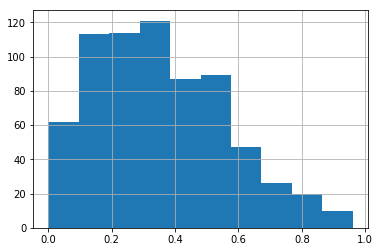

In [400]:
artist_tracks['valence'].hist()

In [321]:
tracks.find({'artist_id': this_artist_id, 'valence': {'$exists': True}}).count()

405

## Lyrics search<a name="lyricssearch"></a>
Now to find the lyrics for each track. 

We start by searching for the Genius ID for the artists.

Note that Genius doesn't like Python-generated requests to its API, so we set the header to pretend to be a command-line `curl` request.

* [Top](#top)

In [49]:
def genius_artist_search(artist_name, per_page=20):
    query = urllib.parse.urlencode({'q': artist_name,
                                    'per_page': str(per_page)
                                   })
    headers = {'Accept': 'application/json',
               'Authorization': 'Bearer ' + config['genius']['token'],
               'User-Agent': 'curl/7.9.8 (i686-pc-linux-gnu) libcurl 7.9.8 (OpenSSL 0.9.6b) (ipv6 enabled)'}
    request = urllib.request.Request('https://api.genius.com/search?{}'.format(query), 
                                     headers=headers,
                                     method='GET')
    with urllib.request.urlopen(request) as f:
            response = json.loads(f.read().decode('utf-8'))
            return response

In [401]:
response = genius_artist_search('Queen')
hits = response['response']['hits']
this_artist_genius_id = [hit['result']['primary_artist']['id'] 
                         for hit in response['response']['hits']][0]
hits, this_artist_genius_id

([{'highlights': [],
   'index': 'song',
   'result': {'annotation_count': 22,
    'api_path': '/songs/496445',
    'full_title': 'Trap Queen by\xa0Fetty\xa0Wap',
    'header_image_thumbnail_url': 'https://images.rapgenius.com/694274eb49f35ea1ad1acc36ab99390e.300x300x1.jpg',
    'header_image_url': 'https://images.rapgenius.com/694274eb49f35ea1ad1acc36ab99390e.640x640x1.jpg',
    'id': 496445,
    'lyrics_owner_id': 104344,
    'lyrics_state': 'complete',
    'path': '/Fetty-wap-trap-queen-lyrics',
    'primary_artist': {'api_path': '/artists/216609',
     'header_image_url': 'https://images.genius.com/cfdf0e6082f7216c2483b34c15420f43.700x393x1.jpg',
     'id': 216609,
     'image_url': 'https://images.genius.com/4c7e86b750a1637b7a2d92f9d0ad558c.496x496x1.jpg',
     'iq': 100,
     'is_meme_verified': True,
     'is_verified': True,
     'name': 'Fetty Wap',
     'url': 'https://genius.com/artists/Fetty-wap'},
    'pyongs_count': 3151,
    'song_art_image_thumbnail_url': 'https://image

In [172]:
hits[0]['result']

{'annotation_count': 45,
 'api_path': '/songs/154468',
 'full_title': 'Lit by\xa0Bas (Ft.\xa0J.\xa0Cole & KQuick)',
 'header_image_thumbnail_url': 'https://images.genius.com/39c68731f53df590ac095e6694ceb1c8.300x300x1.jpg',
 'header_image_url': 'https://images.genius.com/39c68731f53df590ac095e6694ceb1c8.500x500x1.jpg',
 'id': 154468,
 'lyrics_owner_id': 197088,
 'lyrics_state': 'complete',
 'path': '/Bas-lit-lyrics',
 'primary_artist': {'api_path': '/artists/24472',
  'header_image_url': 'https://images.genius.com/c65967fac5fcbbd7798adc18f2413e11.1000x563x1.jpg',
  'id': 24472,
  'image_url': 'https://images.genius.com/6f5338565e5f07aa4ee5c7f21ff0a167.500x500x1.jpg',
  'iq': 2230,
  'is_meme_verified': False,
  'is_verified': True,
  'name': 'Bas',
  'url': 'https://genius.com/artists/Bas'},
 'pyongs_count': 90,
 'song_art_image_thumbnail_url': 'https://images.genius.com/39c68731f53df590ac095e6694ceb1c8.300x300x1.jpg',
 'stats': {'hot': False, 'pageviews': 297572, 'unreviewed_annotation

In [402]:
[(h['result']['primary_artist']['id'], h['result']['primary_artist']['name']) for h in hits]

[(216609, 'Fetty Wap'),
 (92, 'Nicki Minaj'),
 (563, 'Queen'),
 (92, 'Nicki Minaj'),
 (14313, 'Lady Leshurr'),
 (92, 'Nicki Minaj'),
 (783, 'Janelle Monáe'),
 (217208, 'Lil Uzi Vert'),
 (14313, 'Lady Leshurr'),
 (563, 'Queen'),
 (14313, 'Lady Leshurr'),
 (35857, 'Montana of 300'),
 (216609, 'Fetty Wap'),
 (563, 'Queen'),
 (14313, 'Lady Leshurr'),
 (563, 'Queen'),
 (25320, 'Queens of the Stone Age'),
 (56, 'Nas'),
 (327334, 'Christine and the Queens'),
 (110, 'Pharrell Williams')]

In [324]:
this_artist_genius_id

562

In [403]:
this_artist_genius_id = 563

We can now get the song information for each track for each artist. Note that Genius keeps lots of things to do with artists, including sleeve notes and the like. We're just after the lyrics.

In [175]:
def genius_song_search(artist_id):
    songs = pd.DataFrame()
    page = 1
    while page:
        query = urllib.parse.urlencode({'page': page, 'per_page': 20})
        headers = {'Accept': 'application/json',
               'Authorization': 'Bearer ' + config['genius']['token'],
               'User-Agent': 'curl/7.9.8 (i686-pc-linux-gnu) libcurl 7.9.8 (OpenSSL 0.9.6b) (ipv6 enabled)'}
        request = urllib.request.Request('https://api.genius.com/artists/{id}/songs?{query}'.format(id=artist_id,
                                                                                               query=query), 
                                     headers=headers,
                                     method='GET')
        with urllib.request.urlopen(request) as f:
            response = json.loads(f.read().decode('utf-8'))
            page = response['response']['next_page']
            for song in response['response']['songs']:
                if song['path'].endswith('lyrics'):
                    song['_id'] = song['id']
                    genius_tracks.replace_one({'_id': song['id']}, song, upsert=True)

In [404]:
genius_song_search(this_artist_genius_id)
genius_tracks.find({'primary_artist.id': this_artist_genius_id}).count()

382

In [405]:
genius_tracks.find_one({'primary_artist.id': this_artist_genius_id})

{'_id': 1980324,
 'annotation_count': 1,
 'api_path': '/songs/1980324',
 'full_title': 'Love of my life - live in sheffield / 2005 by\xa0Queen',
 'header_image_thumbnail_url': 'https://images.genius.com/781f51bb7041e6b7eeec820fbc413e75.300x225x1.jpg',
 'header_image_url': 'https://images.genius.com/781f51bb7041e6b7eeec820fbc413e75.1000x750x1.jpg',
 'id': 1980324,
 'lyrics_owner_id': 1549345,
 'lyrics_state': 'complete',
 'path': '/Queen-love-of-my-life-live-in-sheffield-2005-lyrics',
 'primary_artist': {'api_path': '/artists/563',
  'header_image_url': 'https://images.genius.com/31ac19166d7332836b753d67550d75f5.590x290x1.jpg',
  'id': 563,
  'image_url': 'https://images.genius.com/781f51bb7041e6b7eeec820fbc413e75.1000x750x1.jpg',
  'is_meme_verified': False,
  'is_verified': False,
  'name': 'Queen',
  'url': 'https://genius.com/artists/Queen'},
 'pyongs_count': None,
 'song_art_image_thumbnail_url': 'https://images.genius.com/781f51bb7041e6b7eeec820fbc413e75.300x225x1.jpg',
 'stats': 

In [406]:
gsongs = pd.DataFrame(list(genius_tracks.find({'primary_artist.id': this_artist_genius_id})))
gsongs.T

,0,1,2,3,4,5,6,7,8,9,...,372,373,374,375,376,377,378,379,380,381
_id,1980324,1746183,1957307,1971439,75243,308915,1530661,308684,2012721,2252949,...,1959261,2000772,309013,309673,2062295,310187,276672,1052870,1980554,308980
annotation_count,1,1,1,1,18,1,1,1,1,1,...,1,1,1,7,1,12,9,1,1,2
api_path,/songs/1980324,/songs/1746183,/songs/1957307,/songs/1971439,/songs/75243,/songs/308915,/songs/1530661,/songs/308684,/songs/2012721,/songs/2252949,...,/songs/1959261,/songs/2000772,/songs/309013,/songs/309673,/songs/2062295,/songs/310187,/songs/276672,/songs/1052870,/songs/1980554,/songs/308980
full_title,Love of my life - live in sheffield / 2005 by ...,Love of My Live by Queen,Love of my life - live at the montreal forum /...,Love of my life - live in budapest / 1986 by Q...,Another One Bites the Dust by Queen,Big Bad Caused A Mighty Fine Sensation by Queen,Death On Two Legs by Queen,Doing All Right by Queen,Flash's Theme Reprise (Victory Celebrations) b...,Flash to the Rescue by Queen,...,White Queen (As It Began) - Live At The Rainbo...,White Queen (As It Began) - Live At The Rainbo...,Who Needs You by Queen,Who Wants to Live Forever by Queen,Wishing well (live) by Queen,You Don't Fool Me by Queen,You're My Best Friend by Queen,(You're So Square) Baby I Don't Care by Queen,(you're so square) baby i don't care - live at...,You Take My Breath Away by Queen
header_image_thumbnail_url,https://images.genius.com/781f51bb7041e6b7eeec...,https://images.genius.com/781f51bb7041e6b7eeec...,https://images.genius.com/781f51bb7041e6b7eeec...,https://images.genius.com/781f51bb7041e6b7eeec...,https://images.genius.com/46cbba7263b21d619ea3...,https://images.genius.com/781f51bb7041e6b7eeec...,https://images.genius.com/ab165af76aefa2f95cca...,https://images.genius.com/ea82e2b5daac0f84eb87...,https://images.genius.com/507e9f4c13bbad63f080...,https://images.genius.com/507e9f4c13bbad63f080...,...,https://images.genius.com/781f51bb7041e6b7eeec...,https://images.genius.com/781f51bb7041e6b7eeec...,https://images.genius.com/587abcd3c795f89809a0...,https://images.genius.com/c93df8c63d9c4efa2296...,https://images.genius.com/781f51bb7041e6b7eeec...,https://images.genius.com/4831c4472c6f3745e394...,https://images.genius.com/823b14934ef9a20a76aa...,https://images.genius.com/781f51bb7041e6b7eeec...,https://images.genius.com/781f51bb7041e6b7eeec...,https://images.genius.com/b9b62a530829bee8fd62...
header_image_url,https://images.genius.com/781f51bb7041e6b7eeec...,https://images.genius.com/781f51bb7041e6b7eeec...,https://images.genius.com/781f51bb7041e6b7eeec...,https://images.genius.com/781f51bb7041e6b7eeec...,https://images.genius.com/46cbba7263b21d619ea3...,https://images.genius.com/781f51bb7041e6b7eeec...,https://images.genius.com/ab165af76aefa2f95cca...,https://images.genius.com/ea82e2b5daac0f84eb87...,https://images.genius.com/507e9f4c13bbad63f080...,https://images.genius.com/507e9f4c13bbad63f080...,...,https://images.genius.com/781f51bb7041e6b7eeec...,https://images.genius.com/781f51bb7041e6b7eeec...,https://images.genius.com/587abcd3c795f89809a0...,https://images.genius.com/c93df8c63d9c4efa2296...,https://images.genius.com/781f51bb7041e6b7eeec...,https://images.genius.com/4831c4472c6f3745e394...,https://images.genius.com/823b14934ef9a20a76aa...,https://images.genius.com/781f51bb7041e6b7eeec...,https://images.genius.com/781f51bb7041e6b7eeec...,https://images.genius.com/b9b62a530829bee8fd62...
id,1980324,1746183,1957307,1971439,75243,308915,1530661,308684,2012721,2252949,...,1959261,2000772,309013,309673,2062295,310187,276672,1052870,1980554,308980
lyrics_owner_id,1549345,1549345,1549345,1549345,48951,354608,1549345,354608,1549345,1549345,...,1549345,1549345,354608,354381,1549345,5431972,1553,1549345,1549345,354608
lyrics_state,complete,complete,complete,complete,complete,complete,complete,complete,complete,complete,...,complete,complete,complete,complete,complete,complete,complete,complete,complete,complete
path,/Queen-love-of-my-life-live-in-sheffield-2005-..

Now we can get the lyrics for each song. We tidy it up as we go, to strip out formatting and the like.

Note the use of [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) to strip out the HTML from the lyrics.

In [96]:
def genius_lyrics(song_url):
    headers = {'Accept': 'application/json',
               'Authorization': 'Bearer ' + config['genius']['token'],
               'User-Agent': 'curl/7.9.8 (i686-pc-linux-gnu) libcurl 7.9.8 (OpenSSL 0.9.6b) (ipv6 enabled)'}
    request = urllib.request.Request(song_url, headers=headers, method='GET')
    html_doc = urllib.request.urlopen(request)
    soup = BeautifulSoup(html_doc, 'html.parser')
#     return soup
    if soup.find('div', class_='lyrics'):
        lyrics = soup.find('div', class_='lyrics').get_text()
    else:
        lyrics = ''
    return sanitise_lyrics(lyrics)

In [97]:
def sanitise_lyrics(lyrics):
    l2 = re.sub('\[[^\]]*\]', '', lyrics)
    l3 = re.sub('\[|\]', '', l2)
    l4 = re.sub('(\s)+', ' ', l3)
    l5 = re.sub('[,.!?;:]', '', l4)
    return l5.strip().lower(), lyrics

In [328]:
genius_tracks.update_many({'primary_artist.id': this_artist_genius_id}, {'$unset': {'lyrics': ''}})

In [407]:
for gsong in genius_tracks.find({'primary_artist.id': this_artist_genius_id}):
    if 'lyrics' not in gsong:
        lyrics, original_lyrics = genius_lyrics(gsong['url'])
        genius_tracks.update_one({'_id': gsong['_id']}, 
                                 {'$set': {'lyrics': lyrics, 'original_lyrics': original_lyrics}})
genius_tracks.find_one({'primary_artist.id': this_artist_genius_id}, ['title', 'lyrics', 'original_lyrics'])

{'_id': 308915,
 'lyrics': "gone and got himself elected president (we want leroy for president) next time you got to hit a bitty baddy weather this time like a shimmy shimmy leather he's a big boy bad boy leroy i don't care where you get him from bring that big bad leroy back want him back",
 'original_lyrics': "\n\n[Verse]\nGone and got himself elected president\n(We want Leroy for President)\n\nNext time, you got to hit a bitty baddy\nWeather\nThis time, like a shimmy, shimmy leather\nHe's a big boy, bad boy, Leroy\nI don't care where you get him from\n\nBring that big bad Leroy back\nWant him back\n\n",
 'title': 'Big Bad Caused A Mighty Fine Sensation'}

In [231]:
genius_tracks.create_index([('original_lyrics', pymongo.TEXT)])

'original_lyrics_text'

In [232]:
[t['original_lyrics'] for t in genius_tracks.find({'$text': {'$search': 'chorus'}}, limit=10)]

["\n\nClaudine's back in jail again\nClaudine's back in jail (again)\nClaudine's back in jail again\nClaudine\n\nClaudine's back in jail again\nClaudine's back in jail (again)\nShe only does it at weekends\nClaudine\nOh, Claudine\n\nNow only Spider knows for sure\nBut he ain't talkin' about it any more\nIs he, Claudine?\n\nThere's blood in the chalet\nAnd blood in the snow\n(She)Washed her hands of the whole damn show\nThe best thing you could do, Claudine\n\nShot him once right through the head\nShot him twice right through the chest\nThe judge says (ruled) it was an accident\nClaudine\nAccidents will happen\n(In the best homes)\n\nAnd Claudine's back in jail again\nClaudine's back in jail again\nClaudine's back in jail again\nClaudine\n\n(Claudine's back in jail again\nClaudine's back in jail again\nClaudine's back in jail again\n\nClaudine) (additional chorus)\nI'll tell you something\nNow Claudine's back in jail again\nClaudine's back in jail again\nClaudine's back in jail again\nC

In [408]:
[t['title'] for t in genius_tracks.find({'$text': {'$search': 'we are not licensed to display'}})]

['I Want It All / We Will Rock You Mash-Up',
 'My Strongest Suit',
 'Looking Tired']

In [409]:
genius_tracks.delete_many({'primary_artist.id': this_artist_genius_id, 
                                         '$text': {'$search': 'licensed'}})

In [410]:
[t['title'] for t in genius_tracks.find({'primary_artist.id': this_artist_genius_id, 
                                         '$text': {'$search': 'immigrant'}})]

['White Man']

In [411]:
[t['title'] for t in genius_tracks.find({'primary_artist.id': this_artist_genius_id})]

['Big Bad Caused A Mighty Fine Sensation',
 "Flash's Theme Reprise (Victory Celebrations)",
 'Flash to the Rescue',
 "Looks Like It's Gonna Be A Good Night - Improv / Live In Budapest / 1986",
 'Big Spender',
 'Bijou',
 'Blag',
 'Misfire',
 'Nevermore',
 'New York',
 'Procession',
 'Track 13',
 'Yeah',
 'A New Life Is Born',
 'Arboria (Planet of the Tree Men)',
 'Battle Theme',
 'Blurred Vision',
 'Chinese Torture',
 'Crash Dive on Mingo City',
 'Dear Friends',
 "Doin' Alright",
 'Doing Alright',
 "Don't Lose Your Head",
 'Drum And Tympani Solo - Live At The Montreal Forum / November 1981',
 'Drum solo - live at the rainbow, london / november 1974',
 'Escape from the Swamp',
 'Execution of Flash',
 'Football Fight',
 'Forever (Piano Version)',
 "Gimme Some Lovin'",
 "Gimme some lovin' - live at wembley stadium / july 1986",
 'God Save The Queen',
 'Impromptu (Live)',
 'In the Death Cell (Love Theme Reprise)',
 'In The Lap Of The Gods',
 'In the Space Capsule (The Love Theme)',
 "It's a

## Matching datasets<a name="matchingdatasets"></a>
Now it's time to match up the datasets. First, we simplify the titles of the tracks, to sidestep differences in punctuation, capitalisation, and the like.

* [Top](#top)

In [102]:
def canonical_name(text):
    t1 = re.sub(' - .*', '', text) # Strip the " - Remastered 2015" suffix
    t2 = re.sub('[^\w\s]', '', t1) # strip all characters except letters, numbers, and whitespace
    t3 = re.sub('\s+', ' ', t2) # collapse whitespace
    return t3.lower() # convert to lowercase and return

In [103]:
canonical_name("A Hard Day's Night - Live / Remastered")

'a hard days night'

Add the simplified title to each track in the Spotify and Genius collections.

In [412]:
for t in tracks.find({'artist_id': this_artist_id}):
    tracks.update_one({'_id': t['_id']}, {'$set': {'ctitle': canonical_name(t['name'])}})
for t in genius_tracks.find({'primary_artist.id': this_artist_genius_id}):
    genius_tracks.update_one({'_id': t['_id']}, {'$set': {'ctitle': canonical_name(t['title'])}})

In [413]:
ctitles = set([t['ctitle'] for t in tracks.find({'artist_id': this_artist_id})])

[(ct, [t['name'] for t in tracks.find({'ctitle': ct})]) 
 for ct in ctitles
 if tracks.find({'ctitle': ct}).count() > 1
]

[('a winters tale',
  ["A Winter's Tale",
   "A Winter's Tale",
   "A Winter's Tale - Cosy Fireside Mix / Remastered 2011"]),
 ('fun it', ['Fun It - Remastered 2011', 'Fun It - Remastered 2011']),
 ('let me entertain you',
  ['Let Me Entertain You - Live At The Montreal Forum / November 1981',
   'Let Me Entertain You - Live, European Tour / 1979',
   'Let Me Entertain You - Remastered 2011',
   'Let Me Entertain You - Remastered 2011',
   'Let Me Entertain You - Live In Montreal / November 1981']),
 ('innuendo', ['Innuendo - Remastered 2011', 'Innuendo - Remastered 2011']),
 ('see what a fool ive been',
  ["See What A Fool I've Been - BBC Session / July 25th 1973, Langham 1 Studio",
   "See What A Fool I've Been - Live At The Hammersmith Odeon, London / 1975",
   "See What A Fool I've Been - Live At The Rainbow, London / March 1974",
   "See What A Fool I've Been - Live BBC Session, London / July 1973 / 2011 Remix",
   'See What A Fool I’ve Been - B-Side Version / Remastered 2011']),


In [414]:
ctitles = set([t['ctitle'] for t in tracks.find({'artist_id': this_artist_id})])

[(ct, [(t['name'], t['liveness']) for t in tracks.find({'ctitle': ct, 'liveness': {'$lt': 0.7}})]) 
 for ct in ctitles
 if tracks.find({'ctitle': ct, 'liveness': {'$lt': 0.7}}).count() > 1
]

[('a winters tale',
  [("A Winter's Tale", 0.321),
   ("A Winter's Tale", 0.321),
   ("A Winter's Tale - Cosy Fireside Mix / Remastered 2011", 0.304)]),
 ('fun it',
  [('Fun It - Remastered 2011', 0.0808),
   ('Fun It - Remastered 2011', 0.0808)]),
 ('innuendo',
  [('Innuendo - Remastered 2011', 0.344),
   ('Innuendo - Remastered 2011', 0.344)]),
 ('see what a fool ive been',
  [("See What A Fool I've Been - BBC Session / July 25th 1973, Langham 1 Studio",
    0.609),
   ("See What A Fool I've Been - Live BBC Session, London / July 1973 / 2011 Remix",
    0.233),
   ('See What A Fool I’ve Been - B-Side Version / Remastered 2011', 0.121)]),
 ('jealousy',
  [('Jealousy - Remastered 2011', 0.243),
   ('Jealousy - Remastered 2011', 0.243)]),
 ('pain is so close to pleasure',
  [('Pain Is So Close To Pleasure - Remastered 2011', 0.169),
   ('Pain Is So Close To Pleasure - Remastered 2011', 0.169),
   ('Pain Is So Close To Pleasure - Single Remix', 0.056)]),
 ('rain must fall',
  [('Rain Mus

In [415]:
[(t['ctitle'], t['name'], g['title']) 
 for t in tracks.find({'artist_id': this_artist_id})
 for g in genius_tracks.find({'ctitle': t['ctitle']})
 if genius_tracks.find({'ctitle': t['ctitle']}).count() > 1]

[('i want it all', 'I Want It All - Single Version', 'I Want It All'),
 ('i want it all',
  'I Want It All - Single Version',
  'I want it all - live in sheffield / 2005'),
 ('hijack my heart', 'Hijack My Heart - B-Side', 'Hijack My Heart'),
 ('hijack my heart', 'Hijack My Heart - B-Side', 'Hijack my heart - b-side'),
 ('stealin', "Stealin' - B-Side", "Stealin'"),
 ('stealin', "Stealin' - B-Side", "Stealin' - b-side"),
 ('one vision', 'One Vision - Remastered 2011', 'One Vision'),
 ('one vision',
  'One Vision - Remastered 2011',
  'One vision - live in budapest / 1986'),
 ('a kind of magic', 'A Kind Of Magic - Remastered 2011', 'A Kind of Magic'),
 ('a kind of magic',
  'A Kind Of Magic - Remastered 2011',
  'A Kind Of Magic - Highlander Version'),
 ('we will rock you',
  'We Will Rock You - Live At Wembley Stadium / July 1986',
  'We Will Rock You'),
 ('we will rock you',
  'We Will Rock You - Live At Wembley Stadium / July 1986',
  'We Will Rock You - LP & JC Remix'),
 ('friends wil

Now to see what the differences are. Find the tracks that are in both collections, and tracks that are in only one.

In [416]:
in_both = set((g['ctitle'], g['title'])
              for g in genius_tracks.find({'primary_artist.id': this_artist_genius_id}, ['ctitle', 'title']) 
              if tracks.find({'ctitle': g['ctitle']}).count())

genius_only = set((g['ctitle'], g['title']) 
                  for g in genius_tracks.find({'primary_artist.id': this_artist_genius_id}, ['ctitle', 'title']) 
                  if not tracks.find({'ctitle': g['ctitle']}).count())

spotify_only = set((s['ctitle'], s['name'])
                   for s in tracks.find({'artist_id': this_artist_id}, ['ctitle', 'name']) 
                   if not genius_tracks.find({'ctitle': s['ctitle']}).count())

len(in_both), len(genius_only), len(spotify_only)

(278, 104, 11)

In [417]:
sorted([s for s in in_both 
 if 'rmx' not in s[0]
 if 'remix' not in s[0]
 if 'live' not in s[0]
 if 'intro' not in s[0]
])

[('39', "'39"),
 ('a human body', 'A Human body'),
 ('a kind of magic', 'A Kind Of Magic - Highlander Version'),
 ('a kind of magic', 'A Kind of Magic'),
 ('a winters tale', "A Winter's Tale"),
 ('action this day', 'Action This Day'),
 ('all dead all dead', 'All Dead, All Dead'),
 ('all gods people', "All God's People"),
 ('another one bites the dust', 'Another One Bites the Dust'),
 ('arboria planet of the tree men', 'Arboria (Planet of the Tree Men)'),
 ('back chat', 'Back Chat'),
 ('back chat', 'Back chat - single remix'),
 ('battle theme', 'Battle Theme'),
 ('bicycle race', 'Bicycle Race'),
 ('big spender', 'Big Spender'),
 ('bijou', 'Bijou'),
 ('body language', 'Body Language'),
 ('bohemian rhapsody', 'Bohemian Rhapsody'),
 ('breakthru', 'Breakthru'),
 ('brighton rock', 'Brighton Rock'),
 ('brighton rock solo', 'Brighton Rock Solo'),
 ('bring back that leroy brown', 'Bring Back That Leroy Brown'),
 ('call me', 'Call Me'),
 ('calling all girls', 'Calling All Girls'),
 ('chinese tor

In [418]:
sorted([g for g in genius_only
 if 'take' not in g[0]
 if 'medley' not in g[0]
 if 'intro' not in g[0]
 if 'live' not in g[0]
])

[('a kind of magic taylor', 'A Kind Of Magic (Taylor)'),
 ('a new life is born', 'A New Life Is Born'),
 ('april lady', 'April Lady'),
 ('baby i dont care', "Baby I Don't Care"),
 ('back to the light', 'Back To The Light'),
 ('bet your bottom dollar bill youre a playboy',
  "Bet Your Bottom Dollar Bill You're A Playboy"),
 ('big bad caused a mighty fine sensation',
  'Big Bad Caused A Mighty Fine Sensation'),
 ('blag', 'Blag'),
 ('blurred vision', 'Blurred Vision'),
 ('calling all girls taylor', 'Calling All Girls (Taylor)'),
 ('crazy little thing called love by queen',
  'Crazy Little Thing Called Love by Queen'),
 ('dead on time may', 'Dead On Time (May)'),
 ('dog with a bone', 'Dog With A Bone'),
 ('doin alright', "Doin' Alright"),
 ('dont loose your head', "Don't Loose Your Head"),
 ('dont try suicide mercury', "Don't Try Suicide (Mercury)"),
 ('earth', 'Earth'),
 ('fat bottomed girls may', 'Fat Bottomed Girls (May)'),
 ('flashs theme reprise victory celebrations',
  "Flash's Theme

In [419]:
sorted(s for s in spotify_only 
 if 'rmx' not in s[0]
 if 'remix' not in s[0]
 if 'live' not in s[0]
 if 'intro' not in s[0]
      )

[('all right now', 'All Right Now - Live In Sheffield / 2005'),
 ('cant get enough', "Can't Get Enough - Live In Sheffield / 2005"),
 ('flashs theme reprise', "Flash's Theme Reprise - Remastered 2011"),
 ('impromptu', 'Impromptu - Live At Wembley Stadium / July 1986'),
 ('jailhouse rock medley',
  'Jailhouse Rock Medley - Live At The Hammersmith Odeon, London / 1975'),
 ('jailhouse rock stupid cupid be bop a lula',
  'Jailhouse Rock / Stupid Cupid / Be Bop A Lula - Live At The Rainbow, London / March 1974'),
 ('last horizon', 'Last Horizon - Live In Sheffield / 2005'),
 ('surfs upschools out', "Surf's Up...School's Out!"),
 ('the kiss', 'The Kiss - Early Version / March 1980'),
 ('untitled', 'Untitled - Remastered 2011'),
 ('wishing well', 'Wishing Well - Live In Sheffield / 2005')]

In [420]:
for ct in ctitles:
    sts = [(t['name']) for t in tracks.find({'artist_id': this_artist_id, 'ctitle': ct})]
    gts = [(t['title']) for t in genius_tracks.find({'primary_artist.id': this_artist_genius_id, 'ctitle': ct})]
    if len(sts) != 1 or len(gts) != 1:
        print(ct, sts, gts)

jailhouse rock medley ['Jailhouse Rock Medley - Live At The Hammersmith Odeon, London / 1975'] []
a winters tale ["A Winter's Tale", "A Winter's Tale", "A Winter's Tale - Cosy Fireside Mix / Remastered 2011"] ["A Winter's Tale"]
i go crazy ['I Go Crazy - B-Side'] ['I Go Crazy', 'I go crazy - b-side']
fun it ['Fun It - Remastered 2011', 'Fun It - Remastered 2011'] ['Fun It']
let me entertain you ['Let Me Entertain You - Live At The Montreal Forum / November 1981', 'Let Me Entertain You - Live, European Tour / 1979', 'Let Me Entertain You - Remastered 2011', 'Let Me Entertain You - Remastered 2011', 'Let Me Entertain You - Live In Montreal / November 1981'] ['Let Me Entertain You', 'Let me entertain you - live at the montreal forum / november 1981']
innuendo ['Innuendo - Remastered 2011', 'Innuendo - Remastered 2011'] ['Innuendo']
see what a fool ive been ["See What A Fool I've Been - BBC Session / July 25th 1973, Langham 1 Studio", "See What A Fool I've Been - Live At The Hammersmith Od

another one bites the dust ['Another One Bites The Dust - Live At The Montreal Forum / November 1981', 'Another One Bites The Dust - Live At Milton Keynes Bowl / June 1982', 'Another One Bites The Dust - Live At Wembley Stadium / July 1986', 'Another One Bites The Dust - Live', 'Another One Bites The Dust - Remastered 2011', 'Another One Bites The Dust - Remastered 2011', 'Another One Bites The Dust - Live In Sheffield / 2005'] ['Another One Bites the Dust']
machines or back to humans ['Machines (Or Back To Humans) - Remastered 2011', 'Machines (Or Back To Humans) - Remastered 2011'] ['Machines (Or Back To Humans)']
the night comes down ['The Night Comes Down - Remastered 2011', 'The Night Comes Down - Remastered 2011', 'The Night Comes Down - De Lane Lea Demo / December 1971'] ['The Night Comes Down']
39 ["'39 - Live In Sheffield / 2005", "'39 - Live, European Tour / 1979", "'39 - Remastered 2011"] ["'39"]
one year of love ['One Year Of Love - Remastered 2011', 'One Year Of Love - Rem

we are the champions ['We Are The Champions - Live At Wembley Stadium / July 1986', 'We Are The Champions - Live At The Montreal Forum / November 1981', 'We Are The Champions - Live At Milton Keynes Bowl / June 1982', 'We Are The Champions - Live', 'We Are The Champions - Live, European Tour / 1979', 'We Are The Champions - Remastered 2011', 'We Are The Champions - Remastered 2011', 'We Are The Champions - Live In Sheffield / 2005'] ['We Are The Champions']
keep yourself alive reprise ['Keep Yourself Alive (Reprise) - Live At The Rainbow, London / November 1974', 'Keep Yourself Alive (Reprise) - Live At The Rainbow, London / March 1974', 'Keep Yourself Alive (Reprise) - Live At The Rainbow, London / November 1974'] ['Keep Yourself Alive (Reprise) - Live At The Rainbow, London / March 1974', 'Keep Yourself Alive (Reprise) - Live At The Rainbow, London / November 1974']
somebody to love ['Somebody To Love - Live At Milton Keynes Bowl / June 1982', 'Somebody To Love - Live At The Montreal

gimme some lovin ["Gimme Some Lovin' - Live At Wembley Stadium / July 1986"] ["Gimme Some Lovin'", "Gimme some lovin' - live at wembley stadium / july 1986"]
vultans theme attack of the hawk men ["Vultan's Theme (Attack Of The Hawk Men) - Remastered 2011", "Vultan's Theme (Attack Of The Hawk Men) - Remastered 2011"] ["Vultan's Theme (Attack of the Hawk Men)"]
hello mary lou goodbye heart ['Hello Mary Lou (Goodbye Heart) - Live At Wembley Stadium / July 1986', 'Hello Mary Lou (Goodbye Heart) - Live'] ['Hello Mary Lou (Goodbye Heart)', 'Hello Mary Lou (Goodbye Heart) - Live At Wembley Stadium / July 1986', 'Hello Mary Lou (Goodbye Heart) - Live In Budapest / 1986']
was it all worth it ['Was It All Worth It - Remastered 2011', 'Was It All Worth It - Remastered 2011'] ['Was It All Worth It']
dead on time ['Dead On Time - Remastered 2011', 'Dead On Time - Remastered 2011'] ['Dead On Time']
in the lap of the godsrevisited ['In The Lap Of The Gods...Revisited - Live At Wembley Stadium / July 

In [112]:
def levenshtein(s1, s2):
    if len(s1) < len(s2):
        return levenshtein(s2, s1)

    # len(s1) >= len(s2)
    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1 # j+1 instead of j since previous_row and current_row are one character longer
            deletions = current_row[j] + 1       # than s2
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]

In [421]:
banned_substrings = ['rmx', 'remix', 'rework', 'live', 'intro', 'medley', 'mix']
genius_and_both = genius_only | in_both
for s in spotify_only:
    if not any(banned in s[1].lower() for banned in banned_substrings):
        gt = min(genius_and_both, key=lambda g: levenshtein(s[0], g[0]))
        d = levenshtein(s[0], gt[0])
        
        print(s, gt, d, gt in in_both)

('flashs theme reprise', "Flash's Theme Reprise - Remastered 2011") ('now im here reprise', "Now I'm Here (Reprise) - Live At The Montreal Forum / November 1981") 8 True
('the kiss', 'The Kiss - Early Version / March 1980') ('the hero', 'The Hero') 4 True
('surfs upschools out', "Surf's Up...School's Out!") ('surfs up schools out', "Surf's Up... School's Out!") 1 False
('untitled', 'Untitled - Remastered 2011') ('fun it', 'Fun It') 5 True


In [361]:
[(t, albums.find_one({'_id': t['album_id']})['name']) for t in tracks.find({'artist_id': this_artist_id}, ['ctitle', 'name', 'album_id'])
   if 'dog bring' in t['ctitle']]

[({'_id': '7ll8muXAomKNStOTzhA4Pk',
   'album_id': '4RlAfzZ4iwr4jQa7Ar9i6t',
   'ctitle': 'black dog bring it on home',
   'name': 'Black Dog / Bring It On Home'},
  'The Song Remains The Same')]

In [114]:
# genius_and_both = genius_only | in_both
# for s in spotify_only:
#     if 'rmx' not in s[0] and 'remix' not in s[0] and 'live' not in s[0]:
# #         album = 
#         candidates = [g for g in genius_and_both if g[1] == s[1]]
#         if candidates:
#             gts = [(g, levenshtein(s[0], g[0])) for g in candidates if levenshtein(s[0], g[0]) < 5]
#             print(s, gts)

Manually fix a couple of errors.

In [248]:
genius_tracks.update_many({'ctitle': 'what did i do god as my witness'}, 
                          {'$set': {'ctitle': 'what did i dogod as my witness'}})
genius_tracks.update_many({'ctitle': 'the ballad of the beaconsfield miners'}, 
                          {'$set': {'ctitle': 'ballad of the beaconsfield miners'}})
genius_tracks.update_many({'ctitle': 'cheer up boys your makeup is running'}, 
                          {'$set': {'ctitle': 'cheer up boys your make up is running'}})
genius_tracks.update_many({'ctitle': 'erase replace'}, 
                          {'$set': {'ctitle': 'erasereplace'}})
# genius_tracks.update_many({'ctitle': 'packt like sardines in a crushd tin box'}, 
#                           {'$set': {'ctitle': 'packt like sardines in a crushed tin box'}})
# genius_tracks.update_many({'ctitle': 'a punchup at a wedding'}, 
#                           {'$set': {'ctitle': 'a punch up at a wedding'}})
# genius_tracks.update_many({'ctitle': 'dollars cents'}, 
#                           {'$set': {'ctitle': 'dollars and cents'}})
# genius_tracks.update_many({'ctitle': 'bullet proofi wish i was'}, 
#                           {'$set': {'ctitle': 'bullet proof i wish i was'}})
# genius_tracks.update_many({'ctitle': 'jumpin jack flash'}, 
#                           {'$set': {'ctitle': 'jumping jack flash'}})
# genius_tracks.update_many({'ctitle': 'far away eyes'}, 
#                           {'$set': {'ctitle': 'faraway eyes'}})

In [362]:
pd.DataFrame(list(albums.find({'artist_id': this_artist_id}, ['artist_name', 'name'])))

,_id,artist_name,name
0,6VH2op0GKIl3WNTbZmmcmI,Led Zeppelin,The Complete BBC Sessions
1,0kTe1sQd9yhDsdG2Zth7X6,Led Zeppelin,Celebration Day
2,4wExFfncaUIqSgoxnqa3Eh,Led Zeppelin,Mothership (Remastered)
3,39BE5332FUDi2TIYD84hm2,Led Zeppelin,How The West Was Won
4,56G9UnPmRifbubzPDJfAyd,Led Zeppelin,Coda (Deluxe Edition)
5,228mANuRrV20jS5DCA0eER,Led Zeppelin,Coda (Remastered)
6,5WRmchevXvk5eXPT0gEuTL,Led Zeppelin,Coda
7,1jCYuXr0Ujke24z1ymBr5U,Led Zeppelin,In Through The Out Door (Deluxe Edition)
8,1W5CtQ7Ng0kP3lXyz7PIT2,Led Zeppelin,In Through The Out Door (Remastered)
9,4wVHvawxZy52Oemd4sGyUm,Led Zeppelin,In Through The Out Door


In [76]:
# in_both = set(g['ctitle'] for g in genius_tracks.find({}, ['ctitle']) if tracks.find({'ctitle': g['ctitle']}).count())
# genius_only = set(g['ctitle'] for g in genius_tracks.find({}, ['ctitle']) if not tracks.find({'ctitle': g['ctitle']}).count())
# spotify_only = set(s['ctitle'] for s in tracks.find({}, ['ctitle']) if not genius_tracks.find({'ctitle': s['ctitle']}).count())
# len(in_both), len(genius_only), len(spotify_only)

(532, 516, 103)

# Remove live and duplicate tracks

In [461]:
this_artist_id = '36QJpDe2go2KgaRleHCDTp'

In [462]:
pd.DataFrame(list(albums.find({'artist_id': this_artist_id}, ['name', 'artist_name', 'release_date'])))

,_id,artist_name,name,release_date
0,6VH2op0GKIl3WNTbZmmcmI,Led Zeppelin,The Complete BBC Sessions,2016-09-16
1,0kTe1sQd9yhDsdG2Zth7X6,Led Zeppelin,Celebration Day,2012-11-19
2,4wExFfncaUIqSgoxnqa3Eh,Led Zeppelin,Mothership (Remastered),2007
3,39BE5332FUDi2TIYD84hm2,Led Zeppelin,How The West Was Won,2003-05-27
4,56G9UnPmRifbubzPDJfAyd,Led Zeppelin,Coda (Deluxe Edition),1982-11-19
5,228mANuRrV20jS5DCA0eER,Led Zeppelin,Coda (Remastered),1982-11-19
6,5WRmchevXvk5eXPT0gEuTL,Led Zeppelin,Coda,1982-11-19
7,1jCYuXr0Ujke24z1ymBr5U,Led Zeppelin,In Through The Out Door (Deluxe Edition),1979-08-15
8,1W5CtQ7Ng0kP3lXyz7PIT2,Led Zeppelin,In Through The Out Door (Remastered),1979-08-15
9,4wVHvawxZy52Oemd4sGyUm,Led Zeppelin,In Through The Out Door,1979-08-15


In [463]:
pd.DataFrame([a for a in albums.find({'artist_id': this_artist_id},
                                     ['name', 'artist_name', 'release_date'])
              if 'live' in a['name'].lower()])

""


In [466]:
pd.DataFrame([a for a in albums.find({'artist_id': this_artist_id},
                                     ['name', 'artist_name', 'release_date'])
              if 'deluxe' in a['name'].lower()])

,_id,artist_name,name,release_date
0,56G9UnPmRifbubzPDJfAyd,Led Zeppelin,Coda (Deluxe Edition),1982-11-19
1,1jCYuXr0Ujke24z1ymBr5U,Led Zeppelin,In Through The Out Door (Deluxe Edition),1979-08-15
2,6vSiY2OVanKKforfEOT2PD,Led Zeppelin,Presence (Deluxe Edition),1976-03-31
3,26tH0kjUhkxBEd3ipGkx3Y,Led Zeppelin,Physical Graffiti (Deluxe Edition),1975-02-24
4,7gS8ozSkvPW3VBPLnXOZ7S,Led Zeppelin,Houses Of The Holy (Deluxe Edition),1973-03-28
5,44Ig8dzqOkvkGDzaUof9lK,Led Zeppelin,Led Zeppelin IV (Deluxe Edition),1971-11-08
6,4xGEiQ7La4japmGrREeLlw,Led Zeppelin,Led Zeppelin III (Remastered Deluxe Edition),1970-10-05
7,58N1RPC3B4mRkjBaug4u3X,Led Zeppelin,Led Zeppelin II (Remastered Deluxe Edition),1969-10-22
8,22BzOOZKYZ2jYYKLpOlnET,Led Zeppelin,Led Zeppelin (Remastered Deluxe Edition),1969-01-12


In [477]:
tracks.find({'artist_id': this_artist_id,
             'ignore': {'$exists': True}
            }).count()

200

In [474]:
tracks.update_many({'artist_id': this_artist_id},
             {'$unset': {'ignore': ''}})

In [478]:
set([a['name'] for t in tracks.find({'artist_id': this_artist_id,
             'ignore': {'$exists': True}
            })
     for a in albums.find({'_id': t['album_id']})])

{'Celebration Day',
 'Coda',
 'Houses Of The Holy',
 'How The West Was Won',
 'Led Zeppelin',
 'Led Zeppelin (Remastered Deluxe Edition)',
 'Led Zeppelin II',
 'Led Zeppelin II (Remastered Deluxe Edition)',
 'Led Zeppelin III (Remastered Deluxe Edition)',
 'Mothership (Remastered)',
 'Presence',
 'The Complete BBC Sessions',
 'The Song Remains The Same'}

In [460]:
list(tracks.find({'album_id': '4May3oxm4OfBv9QwkXylAC'}, ['name']))

[{'_id': '6eGjyvl2LCovg5fstFxAga', 'name': 'Innuendo - Remastered 2011'},
 {'_id': '0lRGxO56Y6ARKEyvpJOX1N',
  'name': "I'm Going Slightly Mad - Remastered 2011"},
 {'_id': '7vHSspNs8MPkOB2A3x9ARJ', 'name': 'Headlong - Remastered 2011'},
 {'_id': '0BkEev4JcKY0Hk54VWwtSO',
  'name': "I Can't Live With You - Remastered 2011"},
 {'_id': '6vUbXquGK5Q3osX5wJXx8q', 'name': "Don't Try So Hard"},
 {'_id': '4srbcly4yWgbyvIww7Dunz',
  'name': 'Ride The Wild Wind - Remastered 2011'},
 {'_id': '6YXCFjv7y12dX97iWcdzks',
  'name': "All God's People - Remastered 2011"},
 {'_id': '6kvmyRoDEiRldGyVyt6zex', 'name': 'These Are The Days Of Our Lives'},
 {'_id': '0SkKJNTOTdOz0jl17Fm6Co', 'name': 'Delilah - Remastered 2011'},
 {'_id': '7BLZzMO6PMGqXSp56jz0Bb', 'name': 'The Hitman - Remastered 2011'},
 {'_id': '6leGGL1jleM6GOJ9CJLkgr',
  'name': 'The Show Must Go On - Remastered 2011'},
 {'_id': '2Jd320a4gWyq7b5id234rh',
  'name': "I Can't Live With You - 1997 Rocks Retake"},
 {'_id': '70zIlBRaU4uKeShAv6QQ3Q

In [468]:
list(albums.find({'artist_id': this_artist_id}, ['name']))

[{'_id': '6VH2op0GKIl3WNTbZmmcmI', 'name': 'The Complete BBC Sessions'},
 {'_id': '0kTe1sQd9yhDsdG2Zth7X6', 'name': 'Celebration Day'},
 {'_id': '4wExFfncaUIqSgoxnqa3Eh', 'name': 'Mothership (Remastered)'},
 {'_id': '39BE5332FUDi2TIYD84hm2', 'name': 'How The West Was Won'},
 {'_id': '56G9UnPmRifbubzPDJfAyd', 'name': 'Coda (Deluxe Edition)'},
 {'_id': '228mANuRrV20jS5DCA0eER', 'name': 'Coda (Remastered)'},
 {'_id': '5WRmchevXvk5eXPT0gEuTL', 'name': 'Coda'},
 {'_id': '1jCYuXr0Ujke24z1ymBr5U',
  'name': 'In Through The Out Door (Deluxe Edition)'},
 {'_id': '1W5CtQ7Ng0kP3lXyz7PIT2',
  'name': 'In Through The Out Door (Remastered)'},
 {'_id': '4wVHvawxZy52Oemd4sGyUm', 'name': 'In Through The Out Door'},
 {'_id': '4RlAfzZ4iwr4jQa7Ar9i6t', 'name': 'The Song Remains The Same'},
 {'_id': '6vSiY2OVanKKforfEOT2PD', 'name': 'Presence (Deluxe Edition)'},
 {'_id': '3uhD8hNpb0m3iIZ18RHH5u', 'name': 'Presence (Remastered)'},
 {'_id': '3xiPkaTzfC48CcsXYgz5v0', 'name': 'Presence'},
 {'_id': '1lZahjeu4Ah

In [476]:
ignore_albums = ['0kTe1sQd9yhDsdG2Zth7X6',
 '39BE5332FUDi2TIYD84hm2',
 '4RlAfzZ4iwr4jQa7Ar9i6t',
 '6VH2op0GKIl3WNTbZmmcmI',
 '4wExFfncaUIqSgoxnqa3Eh',
'5WRmchevXvk5eXPT0gEuTL',
'3xiPkaTzfC48CcsXYgz5v0',
'5phxHbK2GSr7hEu4orLywP',
'70lQYZtypdCALtFVlQAcvx',
'3ycjBixZf7S3WpC5WZhhUK'
                ]


for a in ignore_albums:
    tracks.update_many({'album_id': a}, {'$set': {'ignore': True}})

for a in albums.find({'artist_id': this_artist_id}, ['name']):
    if 'live' in a['name'].lower():
        tracks.update_many({'album_id': a['_id']}, {'$set': {'ignore': True}})
        
for a in albums.find({'artist_id': this_artist_id}, ['name']):
    if 'deluxe' in a['name'].lower() and 'remaster' in a['name'].lower():
        tracks.update_many({'album_id': a['_id']}, {'$set': {'ignore': True}})     

In [470]:
ignore_albums

['0kTe1sQd9yhDsdG2Zth7X6',
 '39BE5332FUDi2TIYD84hm2',
 '4RlAfzZ4iwr4jQa7Ar9i6t',
 '6VH2op0GKIl3WNTbZmmcmI',
 '4wExFfncaUIqSgoxnqa3Eh',
 '5WRmchevXvk5eXPT0gEuTL',
 '3xiPkaTzfC48CcsXYgz5v0',
 '5phxHbK2GSr7hEu4orLywP',
 '70lQYZtypdCALtFVlQAcvx',
 '3ycjBixZf7S3WpC5WZhhUK']

In [250]:
albums.find_one().keys()

dict_keys(['type', 'available_markets', 'tracks', 'id', '_id', 'uri', 'album_type', 'artist_name', 'copyrights', 'release_date', 'popularity', 'images', 'external_ids', 'release_date_precision', 'artist_id', 'label', 'artists', 'name', 'genres', 'external_urls', 'href'])

In [196]:
pd.DataFrame(list(tracks.find({'album_id': '5ju5Ouzan3QwXqQt1Tihbh'}, ['name', 'ctitle'])))

In [370]:
[(a, [t['ctitle'] for t in tracks.find({'album_id': a})]) 
  for a in '1lZahjeu4AhPkg9JARZr5F 0ovKDDAHiTwg4AEjKdgdWo'.split()]

[('1lZahjeu4AhPkg9JARZr5F',
  ['bronyraur',
   'down by the seaside',
   'ten years gone',
   'night flight',
   'the wanton song',
   'boogie with stu',
   'black country woman',
   'sick again',
   'custard pie',
   'the rover',
   'in my time of dying',
   'houses of the holy',
   'trampled under foot',
   'kashmir',
   'in the light']),
 ('0ovKDDAHiTwg4AEjKdgdWo',
  ['custard pie',
   'the rover',
   'in my time of dying',
   'houses of the holy',
   'trampled under foot',
   'kashmir',
   'in the light',
   'bronyraur',
   'down by the seaside',
   'ten years gone',
   'night flight',
   'the wanton song',
   'boogie with stu',
   'black country woman',
   'sick again'])]

In [427]:
al_id = '6YwX6crCLDQTE8ZbtdzFUh'


pd.DataFrame(list({'ctitle': t['ctitle'], 't_name': t['name'],
                  'tt_name': tt['name'], 'tt_alb': tt['album']['name']}
                  for t in tracks.find({'album_id': al_id}, ['name', 'ctitle'])
                  for tt in tracks.find({'ctitle': t['ctitle']}, ['name', 'ctitle', 'album.name', 'album_id'])
                  if tt['album_id'] != al_id))

,ctitle,t_name,tt_alb,tt_name
0,keep yourself alive,Keep Yourself Alive - Remastered 2011,Queen Rock Montreal,Keep Yourself Alive - Live At The Montreal For...
1,keep yourself alive,Keep Yourself Alive - Remastered 2011,On Air,Keep Yourself Alive - BBC Session / February 5...
2,keep yourself alive,Keep Yourself Alive - Remastered 2011,On Air,Keep Yourself Alive - BBC Session / July 25th ...
3,keep yourself alive,Keep Yourself Alive - Remastered 2011,A Night At The Odeon,Keep Yourself Alive - Live At The Hammersmith ...
4,keep yourself alive,Keep Yourself Alive - Remastered 2011,Live At The Rainbow,"Keep Yourself Alive - Live At The Rainbow, Lon..."
5,keep yourself alive,Keep Yourself Alive - Remastered 2011,Live At The Rainbow (Deluxe),"Keep Yourself Alive - Live At The Rainbow, Lon..."
6,keep yourself alive,Keep Yourself Alive - Remastered 2011,Live At The Rainbow (Deluxe),"Keep Yourself Alive - Live At The Rainbow, Lon..."
7,keep yourself alive,Keep Yourself Alive - Remastered 2011,Live Killers,"Keep Yourself Alive - Live, European Tour / 1979"
8,keep yourself alive,Keep Yourself Alive - Remastered 2011,Queen (2011 Remaster),Keep Yourself Alive - Remastered 2011
9,doing alright,Doing Alright - Remastered 2011,Queen (2011 Remaster),Doing Alright - Remastered 2011


In [91]:
# pd.DataFrame(list({'ctitle': t['ctitle'], 't_name': t['name']}
#                   for t in tracks.find({'album_id': '5ju5Ouzan3QwXqQt1Tihbh'}, ['name', 'ctitle'])
#                   if len(list(tracks.find({'ctitle': t['ctitle'],
#                                           'album_id': {'$ne': '5ju5Ouzan3QwXqQt1Tihbh' }}))) == 0))

,ctitle,t_name
0,from me to you,From Me To You - Mono / Remastered
1,i feel fine,I Feel Fine - Remastered 2015
2,day tripper,Day Tripper - Remastered 2015
3,we can work it out,We Can Work It Out - Remastered 2015
4,paperback writer,Paperback Writer - Remastered 2015
5,lady madonna,Lady Madonna - Remastered 2015
6,hey jude,Hey Jude - Remastered 2015
7,the ballad of john and yoko,The Ballad Of John And Yoko - Remastered 2015


In [92]:
# [t for t in tracks.find({}, ['album.name', 'ctitle']) if 'jude' in  t['ctitle']]

[{'_id': '3H7sv3Krffn15BufUuXzf3',
  'album': {'name': '1 (Remastered)'},
  'ctitle': 'hey jude'}]

In [93]:
# pd.DataFrame(list(tracks.find({'album_id': '5XfJmldgWzrc1AIdbBaVZn'}, ['name', 'ctitle'])))

,_id,ctitle,name
0,4edArG2VehvJdwOZfYOxtK,twist and shout,Twist And Shout - Live / Remastered
1,150EAeMGWJRubuH8zyx7h8,shes a woman,She's A Woman - Live / Remastered
2,1fVeHYkyMxrjbjRAD9uWsZ,dizzy miss lizzy,Dizzy Miss Lizzy - Live / Remastered
3,0GRplBEB2FWCKutwMmS6nY,ticket to ride,Ticket To Ride - Live / Remastered
4,1eVymk74iroqhsZxm0Vy3g,cant buy me love,Can't Buy Me Love - Live / Remastered
5,2p5a9gu6NECVSvBtGSU1vm,things we said today,Things We Said Today - Live / Remastered
6,1HyLh5cctOnP186CBi8bhm,roll over beethoven,Roll Over Beethoven - Live / Remastered
7,7fZEWm7TAL2oZDyiYrrgnk,boys,Boys - Live / Remastered
8,21nhooOxso7CCoHPE73w4L,a hard days night,A Hard Day's Night - Live / Remastered
9,1alcPfZWUHh01l4Fnoo5Jt,help,Help! - Live / Remastered


In [94]:
# tracks.update_many({'album_id': '5XfJmldgWzrc1AIdbBaVZn'}, {'$set': {'ignore': True}})

In [95]:
# pd.DataFrame(list(tracks.find({'album_id': '5XfJmldgWzrc1AIdbBaVZn'}, ['name', 'ctitle', 'ignore'])))

,_id,ctitle,ignore,name
0,4edArG2VehvJdwOZfYOxtK,twist and shout,True,Twist And Shout - Live / Remastered
1,150EAeMGWJRubuH8zyx7h8,shes a woman,True,She's A Woman - Live / Remastered
2,1fVeHYkyMxrjbjRAD9uWsZ,dizzy miss lizzy,True,Dizzy Miss Lizzy - Live / Remastered
3,0GRplBEB2FWCKutwMmS6nY,ticket to ride,True,Ticket To Ride - Live / Remastered
4,1eVymk74iroqhsZxm0Vy3g,cant buy me love,True,Can't Buy Me Love - Live / Remastered
5,2p5a9gu6NECVSvBtGSU1vm,things we said today,True,Things We Said Today - Live / Remastered
6,1HyLh5cctOnP186CBi8bhm,roll over beethoven,True,Roll Over Beethoven - Live / Remastered
7,7fZEWm7TAL2oZDyiYrrgnk,boys,True,Boys - Live / Remastered
8,21nhooOxso7CCoHPE73w4L,a hard days night,True,A Hard Day's Night - Live / Remastered
9,1alcPfZWUHh01l4Fnoo5Jt,help,True,Help! - Live / Remastered


In [96]:
# pd.DataFrame(list({'ctitle': t['ctitle'], 't_name': t['name'],
#                   'tt_name': tt['name'], 'tt_alb': tt['album']['name']}
#                   for t in tracks.find({'album_id': '5XfJmldgWzrc1AIdbBaVZn'}, ['name', 'ctitle'])
#                   for tt in tracks.find({'ctitle': t['ctitle'], 
#                                          'album_id': {'$ne': '5XfJmldgWzrc1AIdbBaVZn'}}, 
#                                         ['name', 'ctitle', 'album.name', 'album_id'])))

,ctitle,t_name,tt_alb,tt_name
0,twist and shout,Twist And Shout - Live / Remastered,Please Please Me (Remastered),Twist And Shout - Remastered 2009
1,dizzy miss lizzy,Dizzy Miss Lizzy - Live / Remastered,Help! (Remastered),Dizzy Miss Lizzy - Remastered
2,ticket to ride,Ticket To Ride - Live / Remastered,1 (Remastered),Ticket To Ride - Remastered 2015
3,ticket to ride,Ticket To Ride - Live / Remastered,Help! (Remastered),Ticket To Ride - Remastered
4,cant buy me love,Can't Buy Me Love - Live / Remastered,1 (Remastered),Can't Buy Me Love - Remastered 2015
5,cant buy me love,Can't Buy Me Love - Live / Remastered,A Hard Day's Night (Remastered),Can't Buy Me Love - Remastered
6,things we said today,Things We Said Today - Live / Remastered,A Hard Day's Night (Remastered),Things We Said Today - Remastered
7,roll over beethoven,Roll Over Beethoven - Live / Remastered,With The Beatles (Remastered),Roll Over Beethoven - Remastered
8,roll over beethoven,Roll Over Beethoven - Live / Remastered,On Air (Deluxe),Roll Over Beethoven - Saturday Club / 1963
9,boys,Boys - Live / Remastered,Please Please Me (Remastered),Boys - Remastered 2009


In [97]:
# pd.DataFrame(list({'ctitle': t['ctitle'], 't_name': t['name']}
#                   for t in tracks.find({'album_id': '5XfJmldgWzrc1AIdbBaVZn'}, ['name', 'ctitle'])
#                   if len(list(tracks.find({'ctitle': t['ctitle'],
#                                           'album_id': {'$ne': '5XfJmldgWzrc1AIdbBaVZn' }}))) == 0))

,ctitle,t_name
0,shes a woman,She's A Woman - Live / Remastered
1,long tall sally,Long Tall Sally - Live / Remastered


In [98]:
# tracks.find_one()['album'].keys()

dict_keys(['artists', 'id', 'images', 'href', 'album_type', 'available_markets', 'uri', 'type', 'name', 'external_urls'])

In [99]:
# pd.DataFrame(list({'_id': t['_id'], 'ctitle': t['ctitle'], 't_name': t['name'],
#                   'tt_name': tt['name'], 'tt_alb': tt['album']['name']}
#                   for t in tracks.find({'album_id': '5ju5Ouzan3QwXqQt1Tihbh'}, ['name', 'ctitle'])
#                   for tt in tracks.find({'ctitle': t['ctitle'], 
#                                          'album_id': {'$ne': '5ju5Ouzan3QwXqQt1Tihbh'},
#                                          'ignore': {'$exists': False}}, 
#                                         ['name', 'ctitle', 'album.name', 'album_id'])))

,_id,ctitle,t_name,tt_alb,tt_name
0,5JT7CoUSGNk7mMNkHMQjqr,love me do,Love Me Do - Mono / Remastered,Please Please Me (Remastered),Love Me Do - Remastered 2009
1,7pQAq14Z73YUFMtxCyt0bG,cant buy me love,Can't Buy Me Love - Remastered 2015,A Hard Day's Night (Remastered),Can't Buy Me Love - Remastered
2,0mNQUZEATk2uItMUtiLWK5,a hard days night,A Hard Day's Night - Remastered 2015,A Hard Day's Night (Remastered),A Hard Day's Night - Remastered
3,3nhJDVdUrm6DnDW4iBfpKz,eight days a week,Eight Days A Week - Remastered 2015,Beatles For Sale (Remastered),Eight Days A Week - Remastered
4,6pkjW5srxjzRSKKMrl7et8,ticket to ride,Ticket To Ride - Remastered 2015,Help! (Remastered),Ticket To Ride - Remastered
5,1dfuJYDSIc41cw5RPsaCF1,help,Help! - Remastered 2015,Help! (Remastered),Help! - Remastered
6,63uskN0xLezVg4281wzeQn,yesterday,Yesterday - Remastered 2015,Help! (Remastered),Yesterday - Remastered
7,727YRTVI7pKH1uCnXnyZul,yellow submarine,Yellow Submarine - Remastered 2015,Yellow Submarine (Remastered),Yellow Submarine - Remastered
8,727YRTVI7pKH1uCnXnyZul,yellow submarine,Yellow Submarine - Remastered 2015,Revolver (Remastered),Yellow Submarine - Remastered
9,0TRkjwb4uY3CHb5zhr9bBd,eleanor rigby,Eleanor Rigby - Remastered 2015,Revolver (Remastered),Eleanor Rigby - Remastered


In [100]:
# ignore_tracks = [t['_id']
#                   for t in tracks.find({'album_id': '5ju5Ouzan3QwXqQt1Tihbh'}, ['name', 'ctitle'])
#                   for tt in tracks.find({'ctitle': t['ctitle'], 
#                                          'album_id': {'$ne': '5ju5Ouzan3QwXqQt1Tihbh'},
#                                          'ignore': {'$exists': False}}, 
#                                         ['name', 'ctitle', 'album.name', 'album_id'])]
# ignore_tracks

['5JT7CoUSGNk7mMNkHMQjqr',
 '7pQAq14Z73YUFMtxCyt0bG',
 '0mNQUZEATk2uItMUtiLWK5',
 '3nhJDVdUrm6DnDW4iBfpKz',
 '6pkjW5srxjzRSKKMrl7et8',
 '1dfuJYDSIc41cw5RPsaCF1',
 '63uskN0xLezVg4281wzeQn',
 '727YRTVI7pKH1uCnXnyZul',
 '727YRTVI7pKH1uCnXnyZul',
 '0TRkjwb4uY3CHb5zhr9bBd',
 '5Kw6fC8wyRgMYfBDtEklYM',
 '5Kw6fC8wyRgMYfBDtEklYM',
 '5Kw6fC8wyRgMYfBDtEklYM',
 '56rXurvdpjoSIVggfd5ANS',
 '56rXurvdpjoSIVggfd5ANS',
 '0wFW5NQJdNDJPcZyfYSExx',
 '4ajbplh2IXiJkXjQiq5aqq',
 '6Y6UBWhifUnkJIO2mdy0S3',
 '7iABnSNZciNepqGtjMQxxd',
 '22QadBPe0QCuqraFVAr1m3',
 '0Oroc0HXQaxs8ONgI7dLnw']

In [101]:
# for t in ignore_tracks:
#     tracks.update_one({'_id': t}, {'$set': {'ignore': True}})

In [104]:
# pd.DataFrame(list({'_id': t['_id'], 'ctitle': t['ctitle'], 't_name': t['name'], 't_alb': t['album']['name'],
#                   'tt_name': tt['name'], 'tt_alb': tt['album']['name']}
#                   for t in tracks.find({'artist_id': stones_id, 'ignore': {'$exists': False}}, 
#                                        ['name', 'ctitle', 'album_id', 'album.name'])
#                   for tt in tracks.find({'ctitle': t['ctitle'], 
#                                          'album_id': {'$lt': t['album_id']},
#                                          'ignore': {'$exists': False}}, 
#                                         ['name', 'ctitle', 'album.name', 'album_id'])))

,_id,ctitle,t_alb,t_name,tt_alb,tt_name
0,2uO1HbJhQvmXpjclLmLEeK,jumpin jack flash,Some Girls: Live In Texas '78,Jumpin' Jack Flash - Live,Totally Stripped (Live),Jumpin’ Jack Flash - Live
1,1oluhsJUDe1uAVGwfsFpfg,key to the highway,Dirty Work (Remastered 2009),Key To The Highway - Piano Instrumental/Remast...,Dirty Work,Key To The Highway - Piano Instrumental
2,3v2SyLXNg7IY3I3N6QTZ45,jumpin jack flash,Ladies & Gentlemen (Live),Jumpin' Jack Flash - Live,Some Girls: Live In Texas '78,Jumpin' Jack Flash - Live
3,3v2SyLXNg7IY3I3N6QTZ45,jumpin jack flash,Ladies & Gentlemen (Live),Jumpin' Jack Flash - Live,Totally Stripped (Live),Jumpin’ Jack Flash - Live
4,5Y77giAAAmU9EpfHBDbBV8,you got me rockin,Totally Stripped - Brixton (Live),You Got Me Rockin’ - Live,Totally Stripped - Paris (Live),You Got Me Rockin’ - Live
5,1w9FiXsMcaxb5SD8vIZgm3,jumpin jack flash,Totally Stripped - Brixton (Live),Jumpin’ Jack Flash - Live,Some Girls: Live In Texas '78,Jumpin' Jack Flash - Live
6,1w9FiXsMcaxb5SD8vIZgm3,jumpin jack flash,Totally Stripped - Brixton (Live),Jumpin’ Jack Flash - Live,Ladies & Gentlemen (Live),Jumpin' Jack Flash - Live
7,1w9FiXsMcaxb5SD8vIZgm3,jumpin jack flash,Totally Stripped - Brixton (Live),Jumpin’ Jack Flash - Live,Totally Stripped (Live),Jumpin’ Jack Flash - Live
8,1w9FiXsMcaxb5SD8vIZgm3,jumpin jack flash,Totally Stripped - Brixton (Live),Jumpin’ Jack Flash - Live,Totally Stripped - Paris (Live),Jumpin’ Jack Flash - Live
9,1tEdH58k6r4CvjEhmxxbMC,jumpin jack flash,Totally Stripped - Paris (Live),Jumpin’ Jack Flash - Live,Some Girls: Live In Texas '78,Jumpin' Jack Flash - Live


In [105]:
# # Dirty Work and Dirty Work Remastered
# dw = set(t['ctitle'] for t in tracks.find({'album_id': '1TpcI1LEFVhBvDPSTMPGFG'}))
# dwd = set(t['ctitle'] for t in tracks.find({'album_id': '1WSfNoPDPzgyKFN6OSYWUx'}))

# dw - dwd, dwd - dw

(set(), set())

In [106]:
# # Some Girls and Some Girls Deluxe
# sg = set(t['ctitle'] for t in tracks.find({'album_id': '54sqbAXxR1jFfyXb1WvrHK'}))
# sgd = set(t['ctitle'] for t in tracks.find({'album_id': '6FjXxl9VLURGuubdXUn2J3'}))

# sg - sgd, sgd - sg

(set(),
 {'claudine',
  'do you think i really care',
  'dont be a stranger',
  'i love you too much',
  'keep up blues',
  'no spare parts',
  'petrol blues',
  'so young',
  'tallahassee lassie',
  'we had it all',
  'when youre gone',
  'you win again'})

In [107]:
# for a in ['1TpcI1LEFVhBvDPSTMPGFG', '54sqbAXxR1jFfyXb1WvrHK']:
#     tracks.update_many({'album_id': a}, {'$set': {'ignore': True}})

In [135]:
pd.DataFrame(list(albums.find({}, ['name', 'artist_name', 'release_date'])))

,_id,artist_name,name,release_date
0,5XfJmldgWzrc1AIdbBaVZn,The Beatles,Live At The Hollywood Bowl,2016-09-09
1,5ju5Ouzan3QwXqQt1Tihbh,The Beatles,1 (Remastered),2000-11-13
2,2pCqZLeavM2BMovJXsJEIV,The Beatles,Let It Be (Remastered),1970-05-08
3,2Pqkn9Dq2DFtdfkKAeqgMd,The Beatles,Abbey Road (Remastered),1969-09-26
4,47bcKzmKgmMPHXNVOWpLiu,The Beatles,Yellow Submarine (Remastered),1969-01-17
5,03Qh833fEdVT30Pfs93ea6,The Beatles,The Beatles (Remastered),1968-11-22
6,6P9yO0ukhOx3dvmhGKeYoC,The Beatles,Magical Mystery Tour (Remastered),1967-11-27
7,1PULmKbHeOqlkIwcDMNwD4,The Beatles,Sgt. Pepper's Lonely Hearts Club Band (Remaste...,1967-06-01
8,0PYyrqs9NXtxPhf0CZkq2L,The Beatles,Revolver (Remastered),1966-08-05
9,3OdI6e43crvyAHhaqpxSyz,The Beatles,Rubber Soul (Remastered),1965-12-03


In [109]:
# pd.DataFrame(list({'_id': t['_id'], 'ctitle': t['ctitle'], 't_name': t['name'], 't_alb': t['album']['name'],
#                   'tt_name': tt['name'], 'tt_alb': tt['album']['name']}
#                   for t in tracks.find({'ignore': {'$exists': False}}, 
#                                        ['name', 'ctitle', 'artist_id', 'album_id', 'album.name'])
#                   for tt in tracks.find({'ctitle': t['ctitle'], 
#                                          'artist_id': t['artist_id'],
#                                          'album_id': {'$lt': t['album_id']},
#                                          'ignore': {'$exists': False}}, 
#                                         ['name', 'ctitle', 'album.name', 'album_id'])))

,_id,ctitle,t_alb,t_name,tt_alb,tt_name
0,2uO1HbJhQvmXpjclLmLEeK,jumpin jack flash,Some Girls: Live In Texas '78,Jumpin' Jack Flash - Live,Totally Stripped (Live),Jumpin’ Jack Flash - Live
1,3v2SyLXNg7IY3I3N6QTZ45,jumpin jack flash,Ladies & Gentlemen (Live),Jumpin' Jack Flash - Live,Some Girls: Live In Texas '78,Jumpin' Jack Flash - Live
2,3v2SyLXNg7IY3I3N6QTZ45,jumpin jack flash,Ladies & Gentlemen (Live),Jumpin' Jack Flash - Live,Totally Stripped (Live),Jumpin’ Jack Flash - Live
3,5Y77giAAAmU9EpfHBDbBV8,you got me rockin,Totally Stripped - Brixton (Live),You Got Me Rockin’ - Live,Totally Stripped - Paris (Live),You Got Me Rockin’ - Live
4,1w9FiXsMcaxb5SD8vIZgm3,jumpin jack flash,Totally Stripped - Brixton (Live),Jumpin’ Jack Flash - Live,Some Girls: Live In Texas '78,Jumpin' Jack Flash - Live
5,1w9FiXsMcaxb5SD8vIZgm3,jumpin jack flash,Totally Stripped - Brixton (Live),Jumpin’ Jack Flash - Live,Ladies & Gentlemen (Live),Jumpin' Jack Flash - Live
6,1w9FiXsMcaxb5SD8vIZgm3,jumpin jack flash,Totally Stripped - Brixton (Live),Jumpin’ Jack Flash - Live,Totally Stripped (Live),Jumpin’ Jack Flash - Live
7,1w9FiXsMcaxb5SD8vIZgm3,jumpin jack flash,Totally Stripped - Brixton (Live),Jumpin’ Jack Flash - Live,Totally Stripped - Paris (Live),Jumpin’ Jack Flash - Live
8,1tEdH58k6r4CvjEhmxxbMC,jumpin jack flash,Totally Stripped - Paris (Live),Jumpin’ Jack Flash - Live,Some Girls: Live In Texas '78,Jumpin' Jack Flash - Live
9,1tEdH58k6r4CvjEhmxxbMC,jumpin jack flash,Totally Stripped - Paris (Live),Jumpin’ Jack Flash - Live,Ladies & Gentlemen (Live),Jumpin' Jack Flash - Live


In [110]:
# # Radiohead: I Might be Wrong (live album)
# tracks.update_many({'album_id': '6svTt5o2lUgIrgYDKVmdnD'}, {'$set': {'ignore': True}})

### Copy the lyrics over<a name="copylyrics"></a>
Now can can connect the tracks, let's copy across the lyrics from the Genius collection into the Spotify collection. We'll calculate the lyrical density at the same time.

* [Top](#top)

In [428]:
for t in tracks.find({'artist_id': this_artist_id}, ['ctitle', 'duration_ms']):
    gts = genius_tracks.find({'ctitle': t['ctitle'], 
                              'primary_artist.id': this_artist_genius_id,
                              'lyrics': {'$exists': True}}, ['lyrics', 'original_lyrics'])
    for gt in gts:
        tracks.update_one({'_id': t['_id']}, 
                          {'$set': {'lyrics': gt['lyrics'], 
                                    'original_lyrics': gt['original_lyrics'],
                                    'lyrical_density': 1000 * len(gt['lyrics'].split()) / t['duration_ms']}})

In [429]:
list(genius_tracks.find({'primary_artist.id': this_artist_genius_id,
                              'lyrics': {'$exists': True}}, ['lyrics', 'original_lyrics']))

[{'_id': 308915,
  'lyrics': "gone and got himself elected president (we want leroy for president) next time you got to hit a bitty baddy weather this time like a shimmy shimmy leather he's a big boy bad boy leroy i don't care where you get him from bring that big bad leroy back want him back",
  'original_lyrics': "\n\n[Verse]\nGone and got himself elected president\n(We want Leroy for President)\n\nNext time, you got to hit a bitty baddy\nWeather\nThis time, like a shimmy, shimmy leather\nHe's a big boy, bad boy, Leroy\nI don't care where you get him from\n\nBring that big bad Leroy back\nWant him back\n\n"},
 {'_id': 2012721,
  'lyrics': "he's for everyone of us stand for everyone of us he'll save with a mighty hand every man every woman every child he's the mighty flash no-one but the pure in heart may find the golden grail oh oh - oh oh flash",
  'original_lyrics': "\n\nHe's for everyone of us\nStand for everyone of us\nHe'll save with a mighty hand\nEvery man every woman every ch

In [430]:
tracks.update_many({'artist_id': this_artist_id, 'lyrics': ''}, {'$unset': {'lyrics': ''}})

In [431]:
tracks.find_one({'artist_id': this_artist_id, 'lyrics': {'$exists': True}}, ['lyrics'])

{'_id': '3doVdGo0NrKWDuiAUiWyCY',
 'lyrics': "you and me we are destined you'll agree to spend the rest of our lives with each other the rest of our days like two lovers for ever yeah for ever my bijou"}

## Sentiment analysis<a name="sentimentanalysis"></a>
I couldn't find an easily-installable equivalent to the NRC corpus, so I'm using a sentiment analysis API endpoint from [Text Processing](http://text-processing.com/docs/sentiment.html).

* [Top](#top)

In [432]:
for t in tracks.find({'artist_id': this_artist_id, 
                      'lyrics': {'$exists': True}}, 
                     ['lyrics']):
    text = t['lyrics']
    if text:
        query = urllib.parse.urlencode({'text': text}).encode('ascii')
        headers = {'Accept': 'application/json',
                   'User-Agent': 'curl/7.9.8 (i686-pc-linux-gnu) libcurl 7.9.8 (OpenSSL 0.9.6b) (ipv6 enabled)'}
        request = urllib.request.Request('http://text-processing.com/api/sentiment/', 
                                 headers=headers, data=query)
        with urllib.request.urlopen(request) as f:
            response = json.loads(f.read().decode('utf-8'))
            tracks.update_one({'_id': t['_id']}, {'$set': {'sentiment': response}})

In [378]:
tracks.find_one({'artist_id': this_artist_id, 'sentiment': {'$exists': True}}).keys()

dict_keys(['id', 'valence', 'track_number', 'artist_id', '_id', 'uri', 'ignore', 'tempo', 'original_lyrics', 'ctitle', 'preview_url', 'lyrics', 'loudness', 'album_id', 'sentiment', 'disc_number', 'artists', 'popularity', 'energy', 'type', 'available_markets', 'analysis_url', 'album', 'liveness', 'mode', 'key', 'artist_name', 'acousticness', 'lyrical_density', 'track_href', 'time_signature', 'external_ids', 'name', 'explicit', 'danceability', 'speechiness', 'duration_ms', 'external_urls', 'instrumentalness', 'href'])

In [433]:
tracks.find_one({'artist_id': this_artist_id, 'sentiment': {'$exists': True}})

{'_id': '3doVdGo0NrKWDuiAUiWyCY',
 'acousticness': 0.93,
 'album': {'album_type': 'album',
  'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/1dfeR4HaWDbWqFHLkxsg1d'},
    'href': 'https://api.spotify.com/v1/artists/1dfeR4HaWDbWqFHLkxsg1d',
    'id': '1dfeR4HaWDbWqFHLkxsg1d',
    'name': 'Queen',
    'type': 'artist',
    'uri': 'spotify:artist:1dfeR4HaWDbWqFHLkxsg1d'}],
  'available_markets': ['AD',
   'AR',
   'AT',
   'AU',
   'BE',
   'BG',
   'BO',
   'BR',
   'CH',
   'CL',
   'CO',
   'CR',
   'CY',
   'CZ',
   'DE',
   'DK',
   'DO',
   'EC',
   'EE',
   'ES',
   'FI',
   'FR',
   'GB',
   'GR',
   'GT',
   'HK',
   'HN',
   'HU',
   'ID',
   'IE',
   'IS',
   'IT',
   'JP',
   'LI',
   'LT',
   'LU',
   'LV',
   'MC',
   'MT',
   'MY',
   'NI',
   'NL',
   'NO',
   'NZ',
   'PA',
   'PE',
   'PH',
   'PL',
   'PT',
   'PY',
   'SE',
   'SG',
   'SK',
   'SV',
   'TH',
   'TR',
   'TW',
   'UY',
   'VN'],
  'external_urls': {'spotify': 'https://open.sp

In [434]:
(tracks.find({'artist_id': this_artist_id, 'sentiment': {'$exists': True}}).count(), 
 tracks.find({'artist_id': this_artist_id, 'sentiment': {'$exists': False}}).count())

(640, 49)

In [435]:
tracks.find({'artist_id': this_artist_id, 'sentiment': {'$exists': False}, 'lyrics': {'$exists': True}}).count()

0

In [436]:
pd.DataFrame(list(tracks.find({'artist_id': this_artist_id, 
                               'sentiment': {'$exists': False}, 
                               'lyrics': {'$exists': True}}, 
                              ['name', 'artist_name', 'lyrics'])))

""


In [383]:
list(tracks.find({'artist_id': this_artist_id, 
                  'sentiment': {'$exists': False},
                  'lyrics': {'$exists': True}}, 
                              ['name', 'artist_name', 'lyrics', 'original_lyrics']))

[]

In [384]:
pd.DataFrame(list(tracks.find({'sentiment': {'$exists': False}, 
                               'lyrics': {'$exists': True}}, 
                              ['name', 'artist_name', 'lyrics'])))

""
